## Mise en place de l'execution de code sql avec python

In [1]:
# A décommenter à la première exécution si jupyter se plaint de ne pas trouver oracledb
!pip install --upgrade oracledb

  Using cached oracledb-2.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.1 MB)


In [69]:
# Compléter ici les imports dont vous avez besoin, ne pas modifier ceux déjà présents
import getpass
from os import getenv
import pandas as pd
import oracledb
import warnings
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import statistics
import numpy as np
from ipyleaflet import Map, Marker, basemaps, Icon
import re

In [3]:
# Nécessaire pour éviter les problèmes de session
class Connexion(object):
    def __init__(self, login, password):
        self.conn = oracledb.connect(
            user=login,
            password=password,
            host="oracle.iut-orsay.fr",
            port=1521,
            sid="etudom",
        )
        self.conn.autocommit = False

    def __enter__(self):
        self.conn.autocommit = False
        return self.conn

    def __exit__(self, *args):
        self.conn.close()

In [4]:
# La fonction ci-dessous est à utiliser pour exécuter une requête et stocker les résultats dans un dataframe Pandas sans afficher d’alerte.
# Vous pouvez vous en inspirer pour créer vos propres fonctions.
def requete_vers_dataframe(connexion_data, requete, valeurs = None):
    with Connexion(login=connexion_data['login'], password=connexion_data['password']) as connexion:
        warnings.simplefilter(action='ignore', category=UserWarning)
        if valeurs is not None:
            df = pd.read_sql(requete, connexion, params=valeurs)
        else:
            df = pd.read_sql(requete, connexion)
        warnings.simplefilter("always") 
        return df

In [5]:
# Saisir ci-dessous l'édition des JO qui vous a été attribuée. Cela correspond au LibelleHote dans la table HOTE de la base de données
# Par exemple EDITION_JO = "2020 Summer Olympics"
EDITION_JO = "2012 Summer Olympics"
# Saisir ci-dessous le login court de la base utilisée pour votre carnet
SCHEMA = "belhac1"

In [6]:
# On demande à l'utilisateur son login et mot de passe pour pouvoir accéder à la base de données
if getenv("DB_LOGIN") is None:
    login = input("Login : ")
else:
    login = getenv("DB_LOGIN")
if getenv("DB_PASS") is None:
    password = getpass.getpass("Mot de passe : ")
else:
    password = getenv("DB_PASS")
conn = {'login': login, 'password': password}

Login :  belhac1
Mot de passe :  ········


In [9]:
# On vérifie que l'utilisateur est bien connecté à la base de données, que le schéma est bon, et qu'on trouve la bonne édition des JO
data = requete_vers_dataframe(conn, f"SELECT * FROM {SCHEMA}.HOTE WHERE LibelleHote LIKE (:libelle)",{"libelle":EDITION_JO})
id_hote = int(data.IDHOTE.iloc[0])
print(f"Identifiant de l’hôte : {id_hote}")

Identifiant de l’hôte : 54


# Présentation générale des JO 2012

## JO d'été Londres 2012

Les JO d'été 2012 se sont déroulés dans la ville de Londres (Royaume-Uni) et ses alentours, ainsi que dans d'autres villes telles que : Cardiff, Coventry  majoritairement pour leurs stades de football
>Les épreuves ont eu lieu du  27 juillet au 12 août 2012.

2021 représente la 3ème fois où Londres a accueilli les Jeux Olympiques. Elle est la seule ville à avoir organisé trois fois les JO modernes (depuis 1896). Londres a accueilli les Jeux Olympiques de 1908, 1948 et donc 2012 les derniers en date.

In [10]:
villes = {
    'Londres': (51.5074, -0.1278),
    'Manchester': (53.4839, -2.2446),
    'Coventry': (52.4068, -1.5197),
    'Newcastle': (54.9783, -1.6173),
    'Glasgow': (55.8642, -4.2518),
    'Portland': (50.5495, -2.4351),
    'Hadleigh': (52.0489, 1.0592),
    'Cardiff': (51.4816,-3.1791)
}


centre = (51.5074, -0.1278)  
zoom = 6  
iconRouge = Icon(icon_url='https://raw.githubusercontent.com/pointhi/leaflet-color-markers/master/img/marker-icon-2x-red.png', icon_size=[25, 41], icon_anchor=[12, 41])
carte = Map(center=centre, zoom=zoom, basemap=basemaps.OpenStreetMap.Mapnik)

# Ajout des marqueurs pour chaque ville
for ville, coords in villes.items():
    if ville == 'Londres':
        marqueur = Marker(location=coords, title=ville, draggable=False, icon=iconRouge)
    else:
        marqueur = Marker(location=coords, title=ville, draggable=False)
    carte.add(marqueur)

carte  # Afficher la carte

Map(center=[51.5074, -0.1278], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

### Etude des Epreuves et de leurs Sports

#### Epreuves aux Derniers JO de Londres (1948)

In [11]:
epreuves1948 = requete_vers_dataframe(conn, f"""
SELECT DISTINCT NOMDISCIPLINE as "Discipline",NOMSPORT AS "Sport Associé" FROM {SCHEMA}.DISCIPLINE D 
INNER JOIN {SCHEMA}.SPORT SP ON SP.CODESPORT=D.CODESPORT
INNER JOIN {SCHEMA}.EVENEMENT E ON E.CODEDISCIPLINE=D.CODEDISCIPLINE
INNER JOIN {SCHEMA}.HOTE H ON E.IDHOTE=H.IDHOTE
WHERE LIBELLEHOTE='1948 Summer Olympics'
ORDER BY NOMSPORT
""")
nbEpreuves1948=requete_vers_dataframe(conn, f"""
SELECT COUNT(DISTINCT NOMDISCIPLINE) FROM {SCHEMA}.DISCIPLINE D 
INNER JOIN {SCHEMA}.SPORT SP ON SP.CODESPORT=D.CODESPORT
INNER JOIN {SCHEMA}.EVENEMENT E ON E.CODEDISCIPLINE=D.CODEDISCIPLINE
INNER JOIN {SCHEMA}.HOTE H ON E.IDHOTE=H.IDHOTE
WHERE LIBELLEHOTE='1948 Summer Olympics'
ORDER BY NOMSPORT
""").iloc[0,0]
epreuves1948.iloc[0:nbEpreuves1948]

,Discipline,Sport Associé
0,Diving,Aquatics
1,Swimming,Aquatics
2,Water Polo,Aquatics
3,Art Competitions,Art Competitions
4,Athletics,Athletics
5,Basketball,Basketball
6,Boxing,Boxing
7,Canoe Marathon,Canoeing
8,Canoe Sprint,Canoeing
9,Cycling Road,Cycling


#### Epreuves en 2008

In [12]:
epreuves2008 = requete_vers_dataframe(conn, f"""
SELECT DISTINCT NOMDISCIPLINE as "Discipline",NOMSPORT AS "Sport Associé" FROM {SCHEMA}.DISCIPLINE D 
INNER JOIN {SCHEMA}.SPORT SP ON SP.CODESPORT=D.CODESPORT
INNER JOIN {SCHEMA}.EVENEMENT E ON E.CODEDISCIPLINE=D.CODEDISCIPLINE
INNER JOIN {SCHEMA}.HOTE H ON E.IDHOTE=H.IDHOTE
WHERE LIBELLEHOTE='2008 Summer Olympics'
ORDER BY NOMSPORT
""")
nbEpreuves2008=requete_vers_dataframe(conn, f"""
SELECT COUNT(DISTINCT NOMDISCIPLINE) FROM {SCHEMA}.DISCIPLINE D 
INNER JOIN {SCHEMA}.SPORT SP ON SP.CODESPORT=D.CODESPORT
INNER JOIN {SCHEMA}.EVENEMENT E ON E.CODEDISCIPLINE=D.CODEDISCIPLINE
INNER JOIN {SCHEMA}.HOTE H ON E.IDHOTE=H.IDHOTE
WHERE LIBELLEHOTE='2008 Summer Olympics'
ORDER BY NOMSPORT
""").iloc[0,0]
epreuves2008.iloc[0:nbEpreuves2008]

,Discipline,Sport Associé
0,Artistic Swimming,Aquatics
1,Diving,Aquatics
2,Marathon Swimming,Aquatics
3,Swimming,Aquatics
4,Water Polo,Aquatics
5,Archery,Archery
6,Athletics,Athletics
7,Badminton,Badminton
8,Baseball,Baseball/Softball
9,Softball,Baseball/Softball


#### Epreuves en 2012 (édition la plus récente des JO de Londres)

In [13]:
epreuves2012 = requete_vers_dataframe(conn, f"""
SELECT DISTINCT NOMDISCIPLINE as "Discipline",NOMSPORT AS "Sport Associé" FROM {SCHEMA}.DISCIPLINE D 
INNER JOIN {SCHEMA}.SPORT SP ON SP.CODESPORT=D.CODESPORT
INNER JOIN {SCHEMA}.EVENEMENT E ON E.CODEDISCIPLINE=D.CODEDISCIPLINE
INNER JOIN {SCHEMA}.HOTE H ON E.IDHOTE=H.IDHOTE
WHERE LIBELLEHOTE='2012 Summer Olympics'
ORDER BY NOMSPORT
""")
nbEpreuves2012=requete_vers_dataframe(conn, f"""
SELECT COUNT(DISTINCT NOMDISCIPLINE) FROM {SCHEMA}.DISCIPLINE D 
INNER JOIN {SCHEMA}.SPORT SP ON SP.CODESPORT=D.CODESPORT
INNER JOIN {SCHEMA}.EVENEMENT E ON E.CODEDISCIPLINE=D.CODEDISCIPLINE
INNER JOIN {SCHEMA}.HOTE H ON E.IDHOTE=H.IDHOTE
WHERE LIBELLEHOTE='2012 Summer Olympics'
ORDER BY NOMSPORT
""").iloc[0,0]
epreuves2012.iloc[0:nbEpreuves2012]

,Discipline,Sport Associé
0,Artistic Swimming,Aquatics
1,Diving,Aquatics
2,Marathon Swimming,Aquatics
3,Swimming,Aquatics
4,Water Polo,Aquatics
5,Archery,Archery
6,Athletics,Athletics
7,Badminton,Badminton
8,Basketball,Basketball
9,Boxing,Boxing


#### Conclusions :

On observe qu'il n'y a pas de nouveau sport par rapport à l'édition précédente
 - Tous les sports précédents sont présents sauf 3 : 
     - Wushu
     - Baseball
     - Softball
 - Le nombre de discipline présent entre deux éditions à Londres a doublé, preuve de l'evolution constante des Jeux Olympiques

### Répartition des Epreuves par genre 

In [14]:
repartition=requete_vers_dataframe(conn,f"""
SELECT 
    CASE
        WHEN substr(nomevenement, -5) = ', Men' THEN
            substr(nomevenement,-3)
        WHEN substr(nomevenement, -5) = ' Open' THEN
            substr(nomevenement,-4)
        ELSE
            substr(nomevenement,-5)
    END AS genre,
    COUNT(*) as NOMBRE_EPREUVE 
FROM evenement e
INNER JOIN hote h ON h.idhote = e.idhote
WHERE h.libelleHote = '2012 Summer Olympics'
GROUP BY 
    CASE
        WHEN substr(nomevenement, -5) = ', Men' THEN
            substr(nomevenement,-3)
        WHEN substr(nomevenement, -5) = ' Open' THEN
            substr(nomevenement,-4)
        ELSE
            substr(nomevenement,-5)
    END
order by NOMBRE_EPREUVE DESC
    """) #Je suis obligé de faire le group by ainsi au lieu d'associer un synonyme sous peine de
#causer une erreur oracle
repartition.iloc[0:4]

,GENRE,NOMBRE_EPREUVE
0,Men,162
1,Women,134
2,Open,6
3,Mixed,2


### Répartition des Médailles parmi les pays

#### Graphique pour les médailles totales

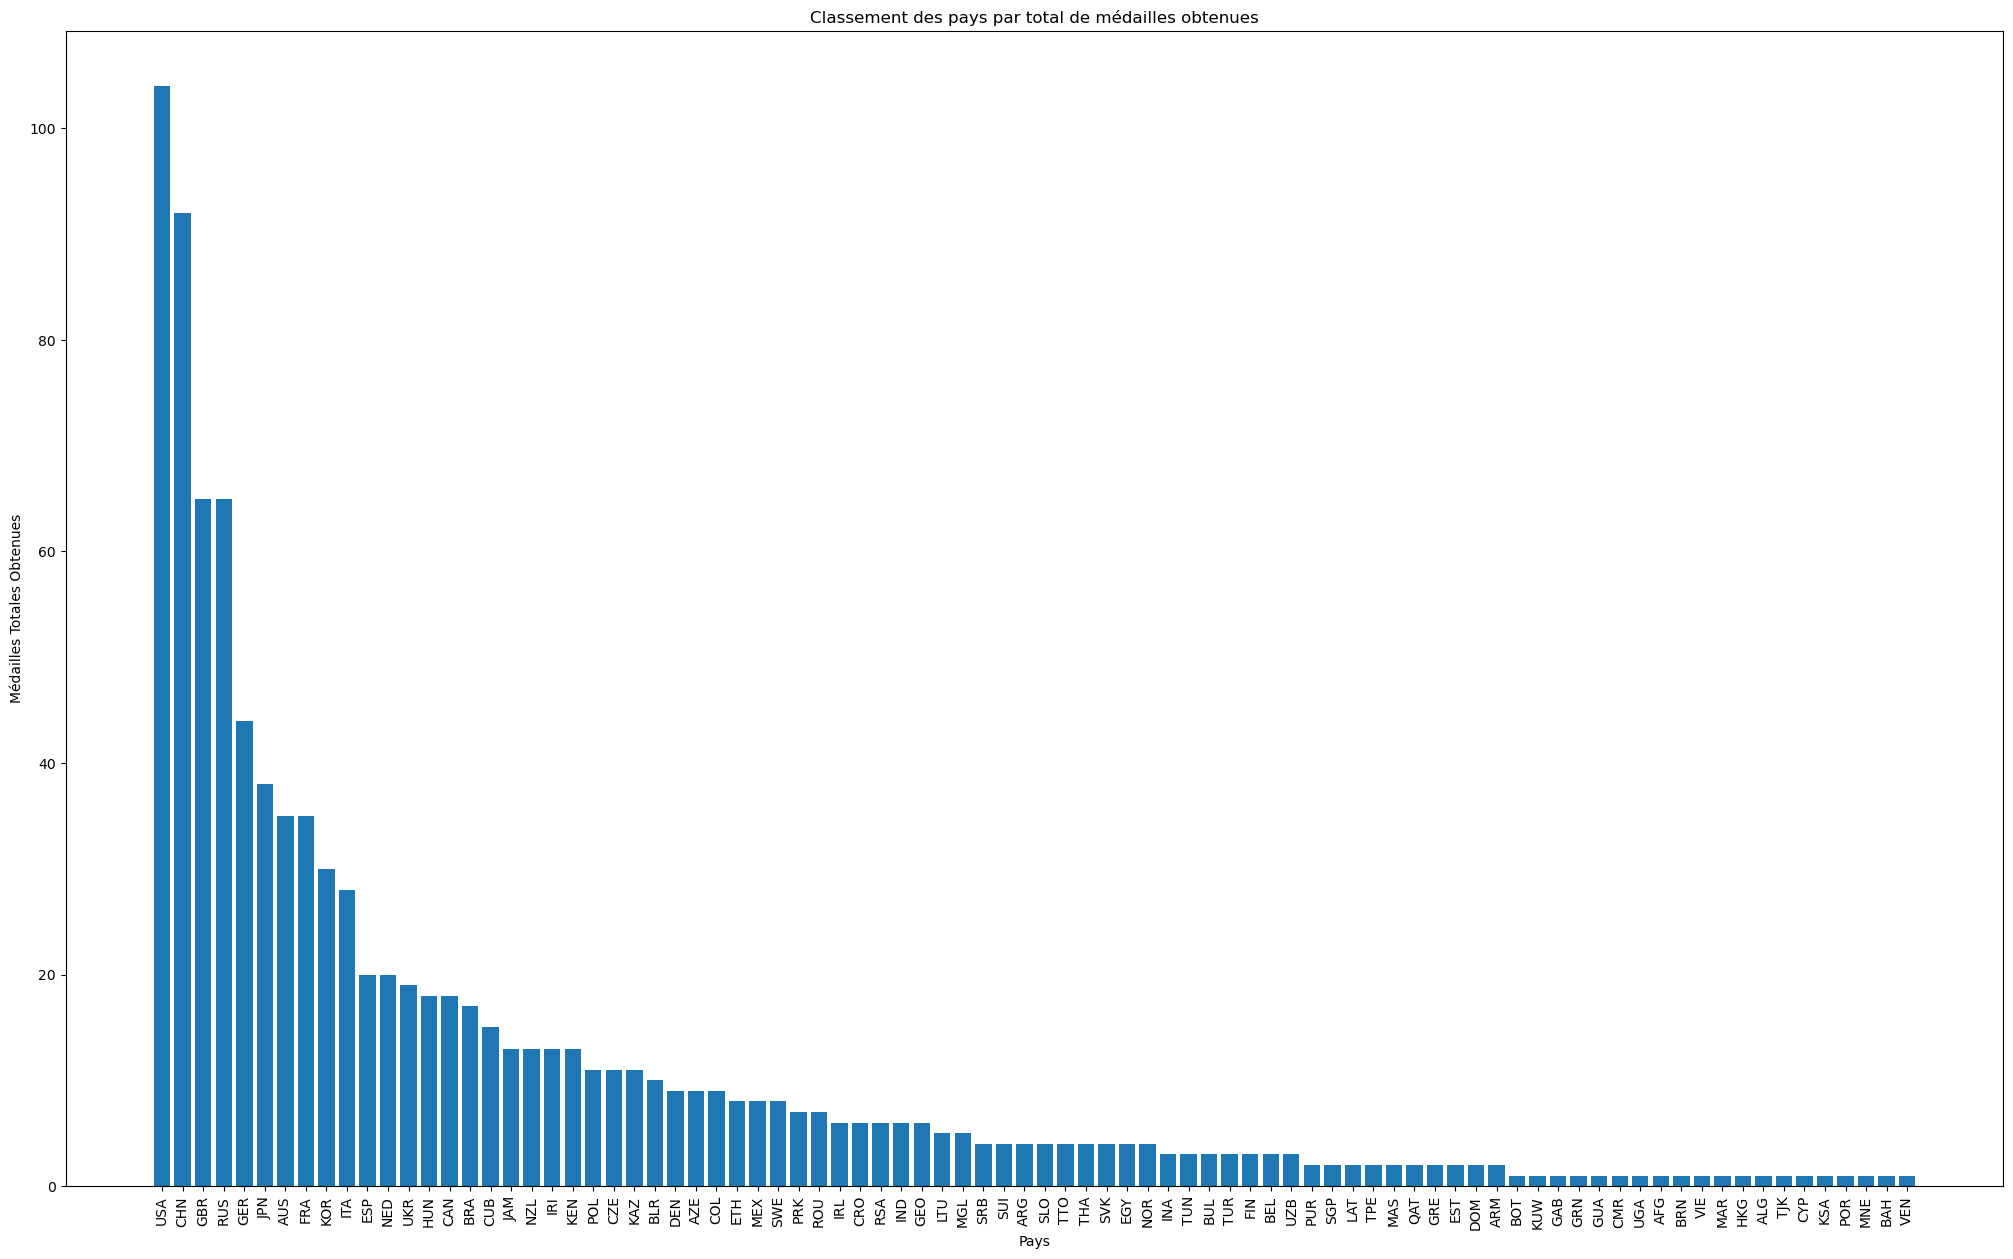

,CODENOC,OR_MEDAILLES,ARGENT_MEDAILLES,BRONZE_MEDAILLES,TOTAL_MEDAILLES
0,USA,48,26,30,104
1,CHN,39,31,22,92
2,GBR,29,18,18,65
3,RUS,18,21,26,65
4,GER,11,20,13,44
5,JPN,7,14,17,38
6,AUS,8,15,12,35
7,FRA,11,11,13,35
8,KOR,13,9,8,30
9,ITA,8,9,11,28


In [15]:
tabMedaillesTotals = requete_vers_dataframe(conn, f"""
    SELECT * FROM {SCHEMA}.MEDAILLES_NOC_2012 ORDER BY TOTAL_MEDAILLES DESC
""")
nbPays = requete_vers_dataframe(conn, f"""
    SELECT COUNT(*) FROM {SCHEMA}.MEDAILLES_NOC_2012 WHERE TOTAL_MEDAILLES != 0
""").iloc[0,0]

# On s'assure que nbPays ne dépasse pas le nombre de lignes disponibles
nbPays = min(nbPays, len(tabMedaillesTotals))

nocs = []
nbMed = []
nbMedOr = []
nbMedArgent = []
nbMedBronze = []

for i in range(nbPays):
    pays = tabMedaillesTotals.iloc[i]
    nocs.append(pays['CODENOC'])
    nbMed.append(pays['TOTAL_MEDAILLES'])
    nbMedOr.append(pays['OR_MEDAILLES'])
    nbMedArgent.append(pays['ARGENT_MEDAILLES'])
    nbMedBronze.append(pays['BRONZE_MEDAILLES'])
    
plt.figure(figsize=(25, 15))
plt.bar(nocs, nbMed)
plt.xlabel('Pays')
plt.ylabel('Médailles Totales Obtenues')
plt.title('Classement des pays par total de médailles obtenues')
plt.xticks(rotation=90)  
plt.show()
tabMedaillesTotals.iloc[0:10]

Ce tableau n'est qu'un extrait du total du classement mais permet un aperçu sur les valeurs des pays ayant le mieux performé

#### Graphique pour les médailles d'Or

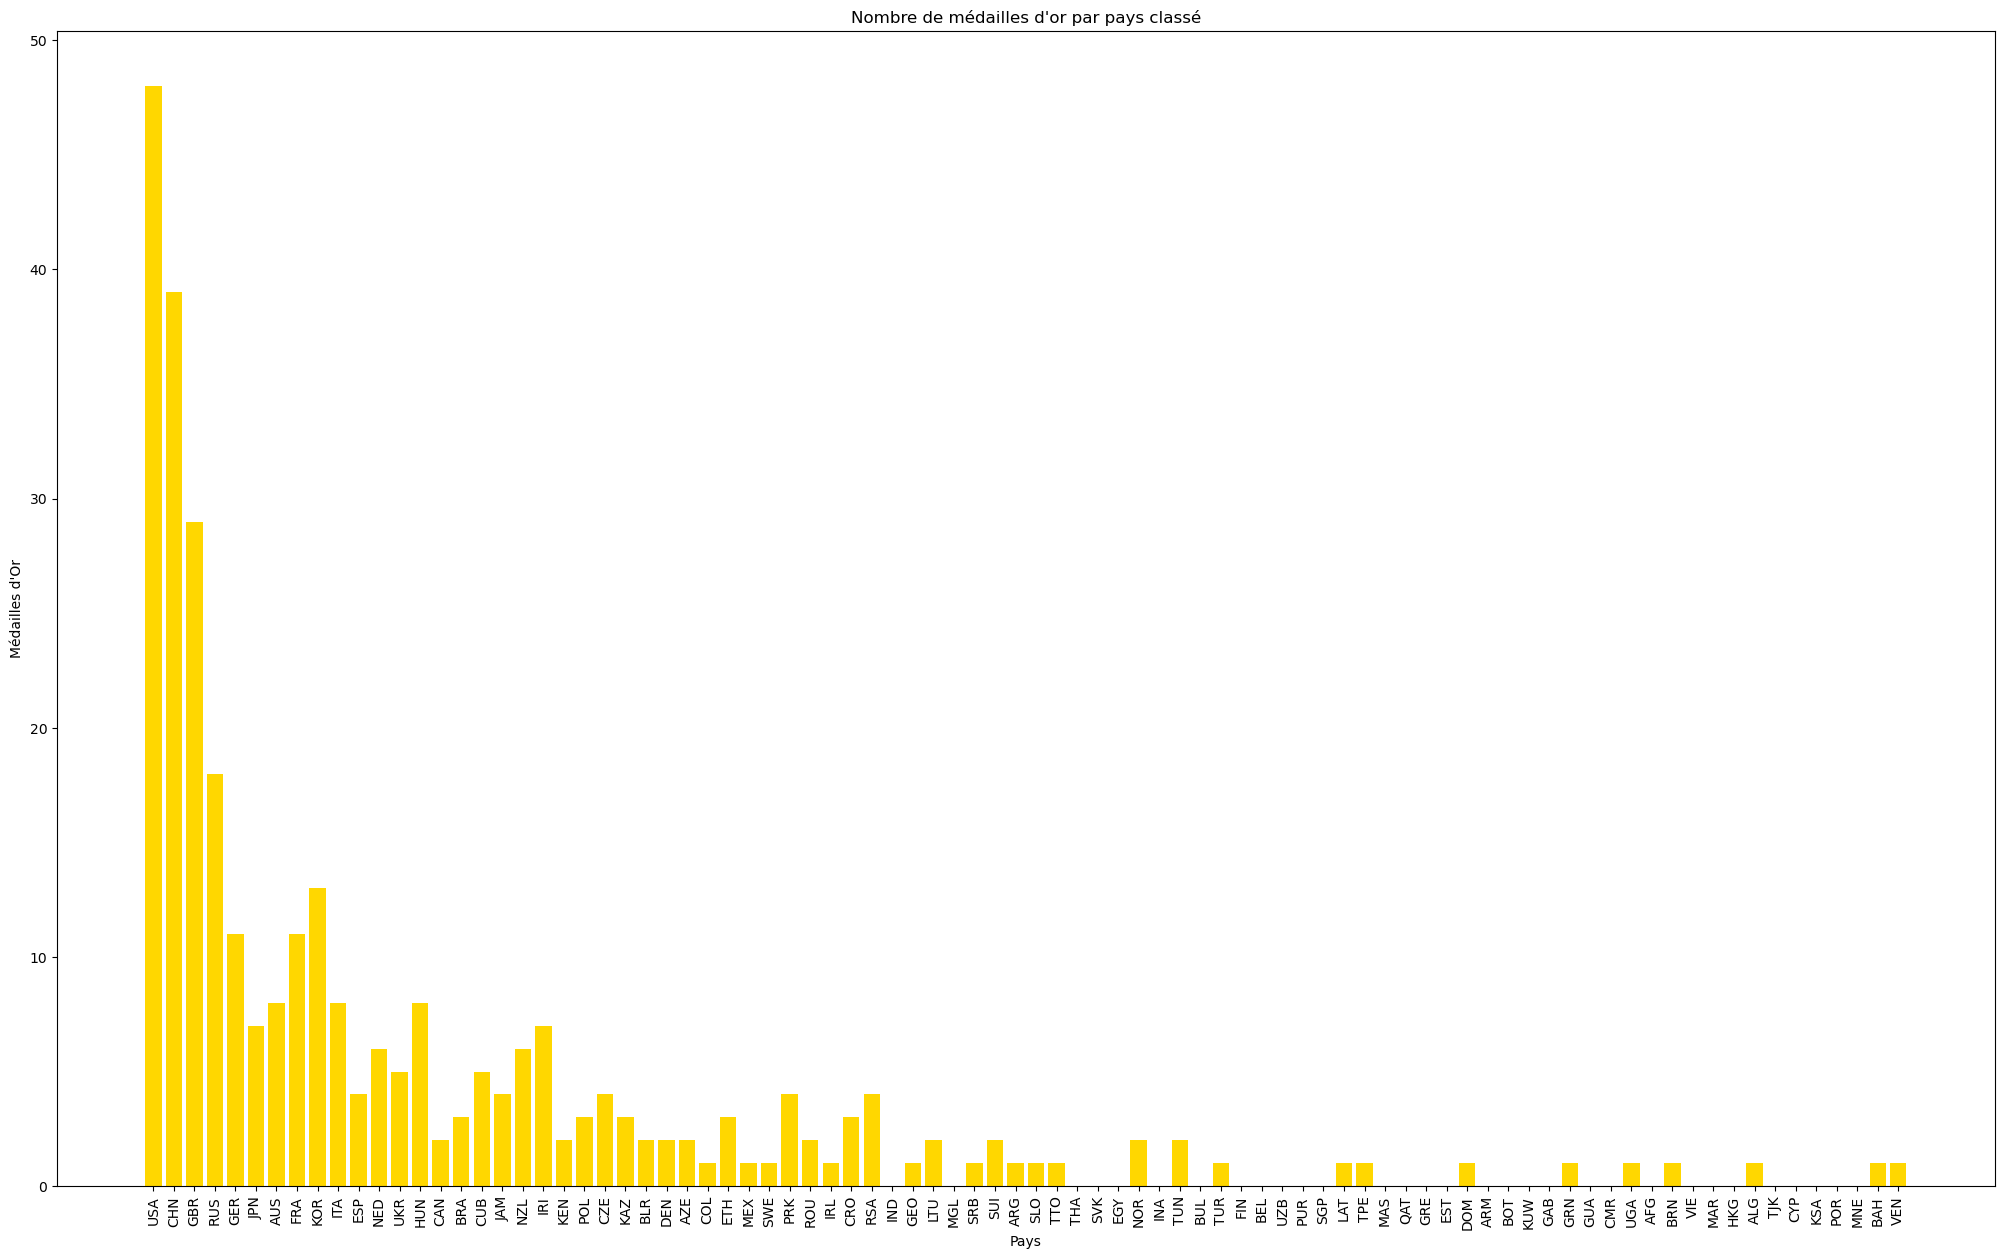

In [16]:
plt.figure(figsize=(25, 15))
plt.bar(nocs, nbMedOr, color='gold')
plt.xlabel('Pays')
plt.ylabel('Médailles d\'Or')
plt.title('Nombre de médailles d\'or par pays classé')
plt.xticks(rotation=90)
plt.show()

#### Graphique pour les médailles d'Argent

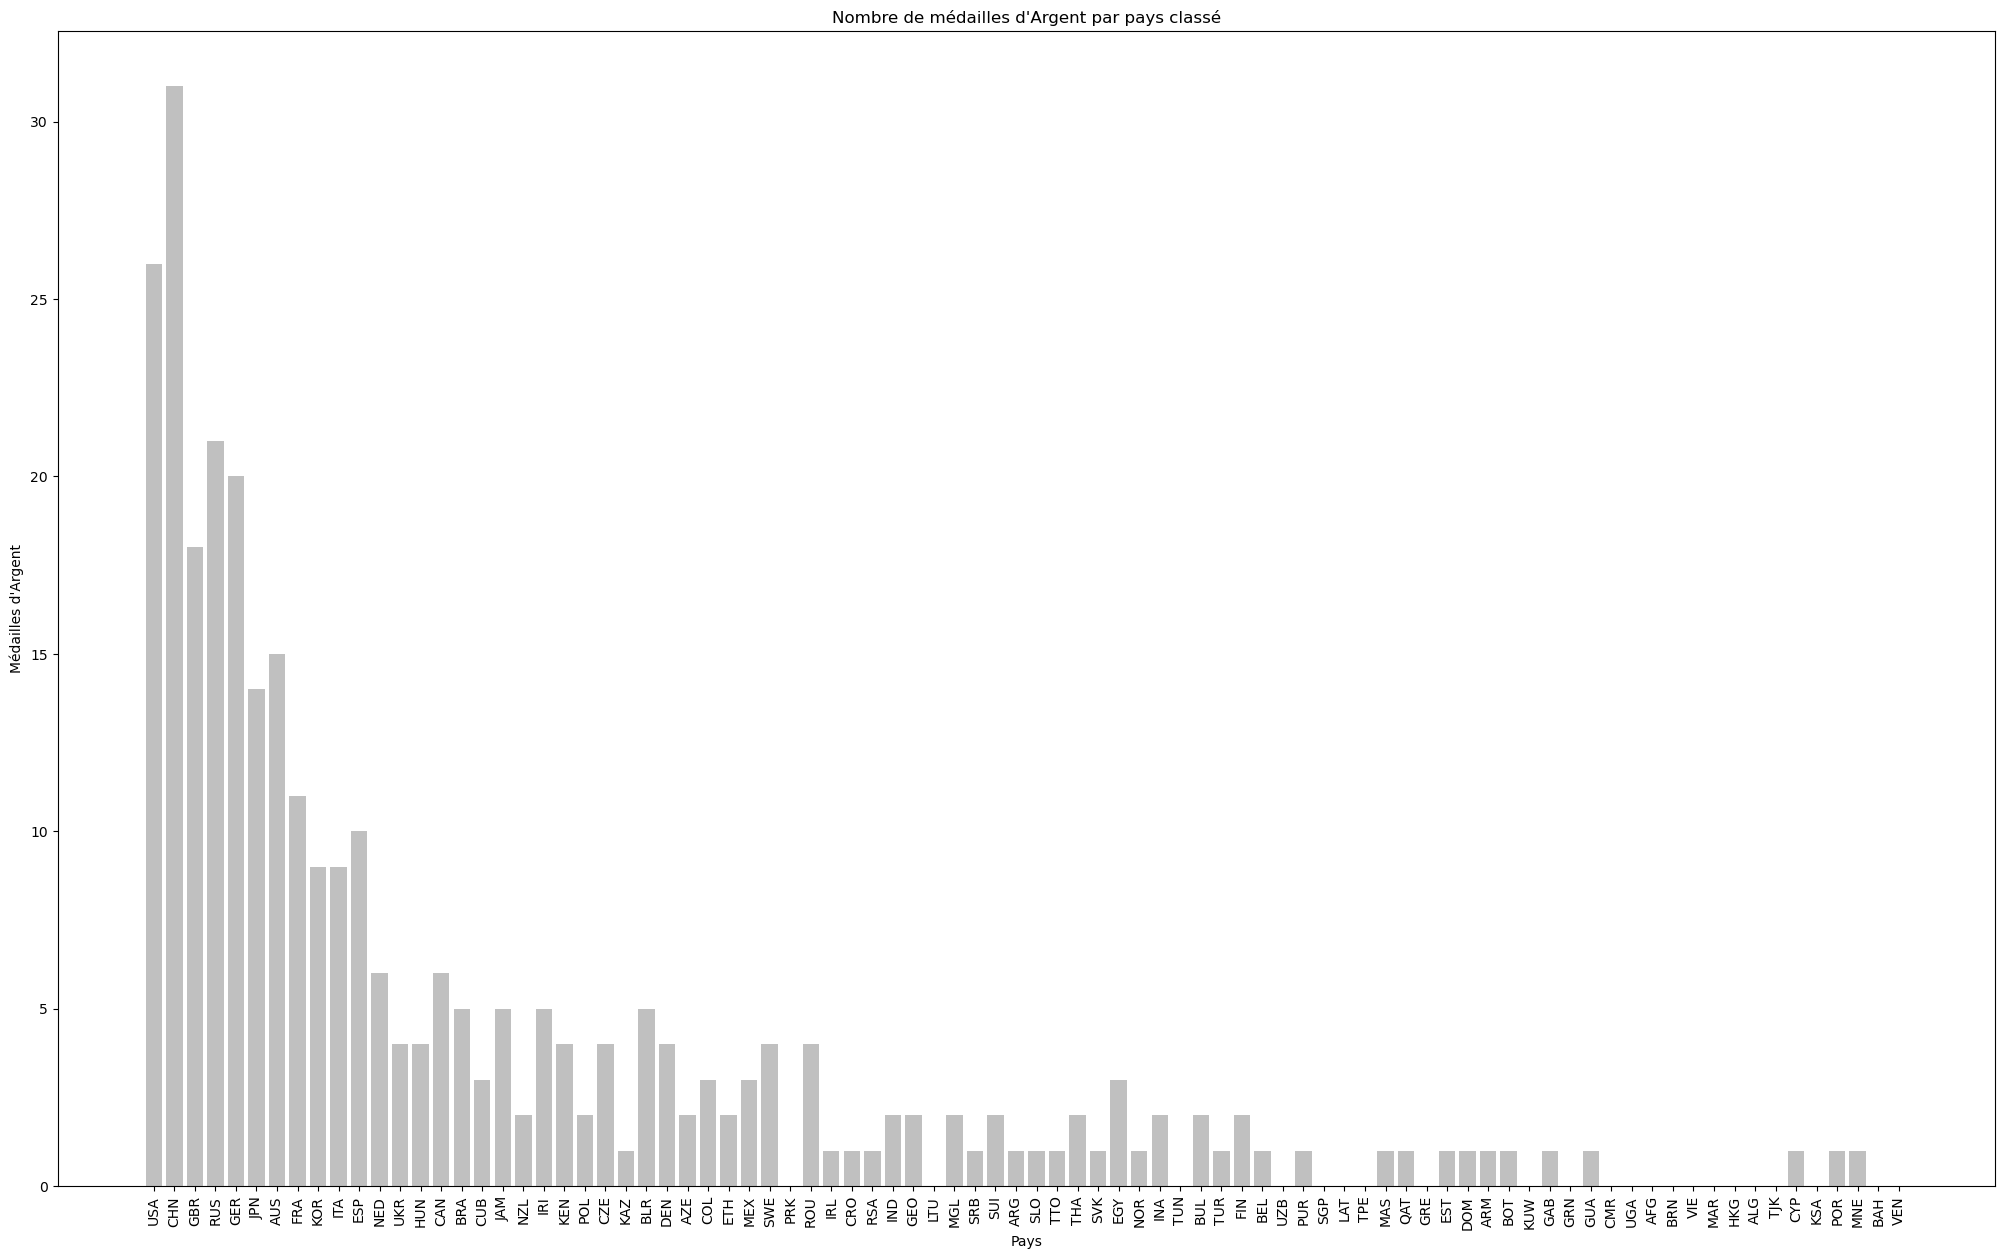

In [17]:
plt.figure(figsize=(25, 15))
plt.bar(nocs, nbMedArgent, color='silver')
plt.xlabel('Pays')
plt.ylabel('Médailles d\'Argent')
plt.title('Nombre de médailles d\'Argent par pays classé')
plt.xticks(rotation=90)
plt.show()

#### Graphique pour les médailles de Bronze

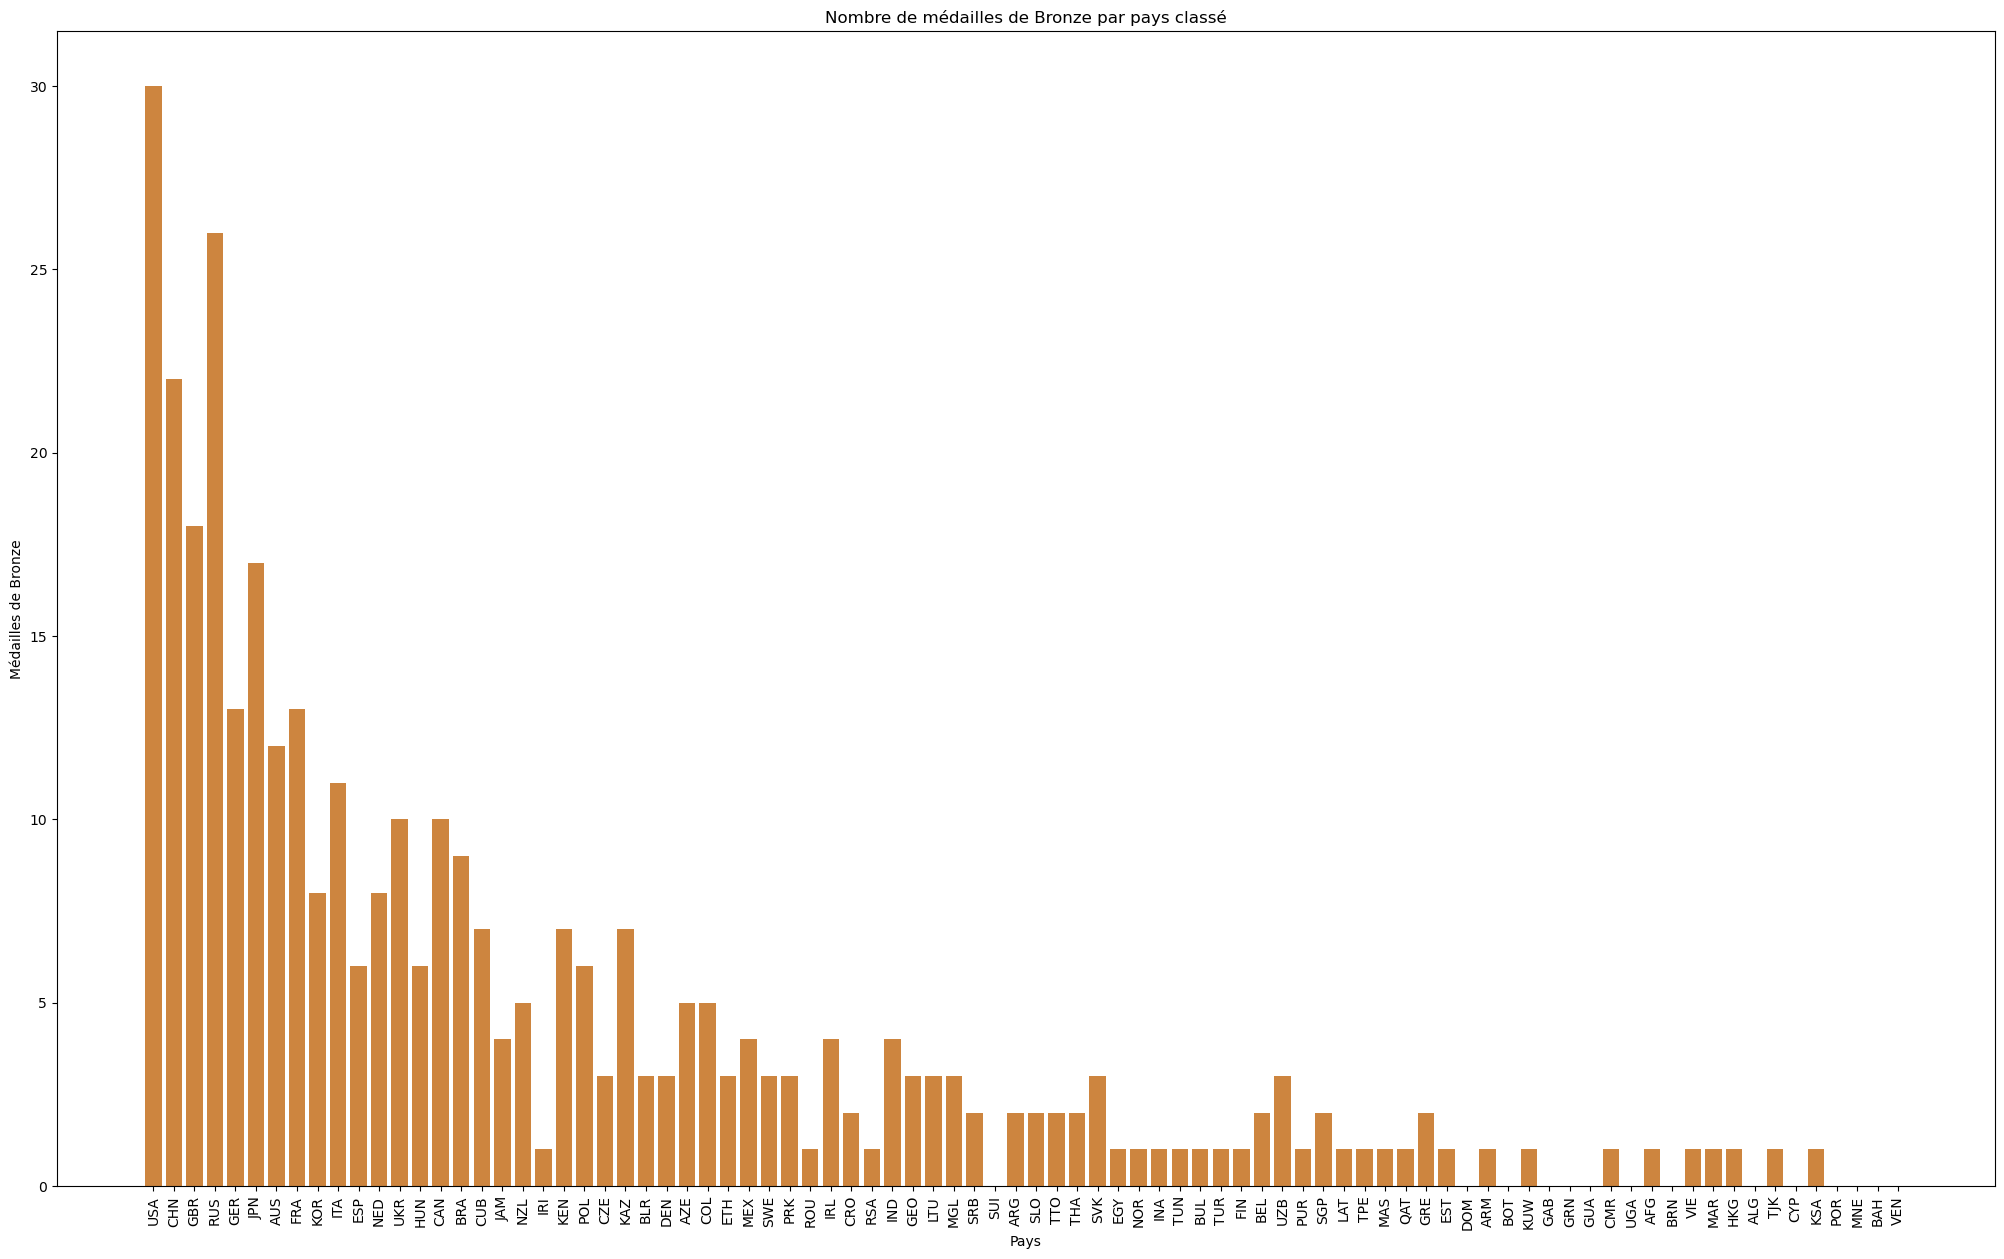

In [18]:
plt.figure(figsize=(25, 15))
plt.bar(nocs, nbMedBronze, color='peru')
plt.xlabel('Pays')
plt.ylabel('Médailles de Bronze')
plt.title('Nombre de médailles de Bronze par pays classé')
plt.xticks(rotation=90)
plt.show()

# Comparaison de cette édition avec les précédentes

### Etude de la Répartition par genre et par pays
##### Extrait du tableau des résultats

In [19]:
medailles_genre_pays_2012 = requete_vers_dataframe(conn,f"""SELECT * FROM {SCHEMA}.MEDAILLES_NOC_GENRE_2012 WHERE GENRE IS NOT NULL""")
medailles_genre_pays_2012.iloc[0:10]

,CODENOC,GENRE,OR_MEDAILLES,ARGENT_MEDAILLES,BRONZE_MEDAILLES,TOTAL_MEDAILLES
0,CHN,Male,25,10,9,44
1,CHN,Female,24,10,15,49
2,USA,Female,20,22,18,60
3,USA,Male,17,15,21,53
4,RUS,Male,15,4,17,36
5,GBR,Male,13,13,10,36
6,GER,Male,12,3,7,22
7,GBR,Female,11,7,9,27
8,RUS,Female,10,7,6,23
9,GER,Female,8,6,4,18


Statistiques par années de JO par genre et par médailles

In [20]:
# Récupération des données
tabTotalFemmes2012 = requete_vers_dataframe(conn, """
    SELECT * FROM MEDAILLES_NOC_GENRE_2012 
    WHERE GENRE ='Female'
""")
tabTotalHommes2012 = requete_vers_dataframe(conn, """
    SELECT * FROM MEDAILLES_NOC_GENRE_2012 
    WHERE GENRE ='Male'
""")
nbTotalFemmes2012 = requete_vers_dataframe(conn, """
    SELECT COUNT(*) AS NBMED FROM ATHL_2012 
    WHERE GENRE ='Female'
""").iloc[0, 0]
nbTotalHommes2012 = requete_vers_dataframe(conn, """
    SELECT COUNT(*) FROM ATHL_2012 
    WHERE GENRE ='Male'
""").iloc[0, 0]

# Conversion en listes
listeMedaillesFemmes2012 = tabTotalFemmes2012['TOTAL_MEDAILLES'].tolist()
listeMedaillesHommes2012 = tabTotalHommes2012['TOTAL_MEDAILLES'].tolist()

listeOrFemmes2012 = tabTotalFemmes2012['OR_MEDAILLES'].tolist()
listeOrHommes2012 = tabTotalHommes2012['OR_MEDAILLES'].tolist()
listeArgentFemmes2012 = tabTotalFemmes2012['ARGENT_MEDAILLES'].tolist()
listeArgentHommes2012 = tabTotalHommes2012['ARGENT_MEDAILLES'].tolist()
listeBronzeFemmes2012 = tabTotalFemmes2012['BRONZE_MEDAILLES'].tolist()
listeBronzeHommes2012 = tabTotalHommes2012['BRONZE_MEDAILLES'].tolist()

# Fonction pour calculer les statistiques
def calculate_statistics(liste):
    stats = {
        'Moyenne': np.mean(liste),
        'Ecart-type': np.std(liste),
        'Min': np.min(liste),
        'Max': np.max(liste),
        'Q1': np.percentile(liste, 25),
        'Mediane': np.median(liste),
        'Q3': np.percentile(liste, 75)
    }
    return stats

# Calcul des statistiques pour les femmes
statsFemmes2012 = {
    'Total': calculate_statistics(listeMedaillesFemmes2012),
    'Or': calculate_statistics(listeOrFemmes2012),
    'Argent': calculate_statistics(listeArgentFemmes2012),
    'Bronze': calculate_statistics(listeBronzeFemmes2012)
}

# Calcul des statistiques pour les hommes
statsHommes2012 = {
    'Total': calculate_statistics(listeMedaillesHommes2012),
    'Or': calculate_statistics(listeOrHommes2012),
    'Argent': calculate_statistics(listeArgentHommes2012),
    'Bronze': calculate_statistics(listeBronzeHommes2012)
}

# Création des DataFrames pour un affichage plus lisible
df_statsFemmes2012 = pd.DataFrame(statsFemmes2012).T
df_statsHommes2012 = pd.DataFrame(statsHommes2012).T

# Récupération des données
tabTotalFemmes2008 = requete_vers_dataframe(conn, """
    SELECT * FROM MEDAILLES_NOC_GENRE_2008 
    WHERE GENRE ='Female'
""")
tabTotalHommes2008 = requete_vers_dataframe(conn, """
    SELECT * FROM MEDAILLES_NOC_GENRE_2008 
    WHERE GENRE ='Male'
""")
nbTotalFemmes2008 = requete_vers_dataframe(conn, """
    SELECT COUNT(*) AS NBMED FROM ATHL_2008 
    WHERE GENRE ='Female'
""").iloc[0, 0]
nbTotalHommes2008 = requete_vers_dataframe(conn, """
    SELECT COUNT(*) FROM ATHL_2008 
    WHERE GENRE ='Male'
""").iloc[0, 0]

# Conversion en listes
listeMedaillesFemmes2008 = tabTotalFemmes2008['TOTAL_MEDAILLES'].tolist()
listeMedaillesHommes2008 = tabTotalHommes2008['TOTAL_MEDAILLES'].tolist()

listeOrFemmes2008 = tabTotalFemmes2008['OR_MEDAILLES'].tolist()
listeOrHommes2008 = tabTotalHommes2008['OR_MEDAILLES'].tolist()
listeArgentFemmes2008 = tabTotalFemmes2008['ARGENT_MEDAILLES'].tolist()
listeArgentHommes2008 = tabTotalHommes2008['ARGENT_MEDAILLES'].tolist()
listeBronzeFemmes2008 = tabTotalFemmes2008['BRONZE_MEDAILLES'].tolist()
listeBronzeHommes2008 = tabTotalHommes2008['BRONZE_MEDAILLES'].tolist()

# Fonction pour calculer les statistiques
def calculate_statistics(liste):
    stats = {
        'Moyenne': np.mean(liste),
        'Ecart-type': np.std(liste),
        'Min': np.min(liste),
        'Max': np.max(liste),
        'Q1': np.percentile(liste, 25),
        'Mediane': np.median(liste),
        'Q3': np.percentile(liste, 75)
    }
    return stats

# Calcul des statistiques pour les femmes
statsFemmes2008 = {
    'Total': calculate_statistics(listeMedaillesFemmes2008),
    'Or': calculate_statistics(listeOrFemmes2008),
    'Argent': calculate_statistics(listeArgentFemmes2008),
    'Bronze': calculate_statistics(listeBronzeFemmes2008)
}

# Calcul des statistiques pour les hommes
statsHommes2008 = {
    'Total': calculate_statistics(listeMedaillesHommes2008),
    'Or': calculate_statistics(listeOrHommes2008),
    'Argent': calculate_statistics(listeArgentHommes2008),
    'Bronze': calculate_statistics(listeBronzeHommes2008)
}

# Création des DataFrames pour un affichage plus lisible
df_statsFemmes2008 = pd.DataFrame(statsFemmes2008).T
df_statsHommes2008 = pd.DataFrame(statsHommes2008).T

# Récupération des données
tabTotalFemmes2004 = requete_vers_dataframe(conn, """
    SELECT * FROM MEDAILLES_NOC_GENRE_2004 
    WHERE GENRE ='Female'
""")
tabTotalHommes2004 = requete_vers_dataframe(conn, """
    SELECT * FROM MEDAILLES_NOC_GENRE_2004 
    WHERE GENRE ='Male'
""")
nbTotalFemmes2004 = requete_vers_dataframe(conn, """
    SELECT COUNT(*) AS NBMED FROM ATHL_2004 
    WHERE GENRE ='Female'
""").iloc[0, 0]
nbTotalHommes2004 = requete_vers_dataframe(conn, """
    SELECT COUNT(*) FROM ATHL_2004 
    WHERE GENRE ='Male'
""").iloc[0, 0]

# Conversion en listes
listeMedaillesFemmes2004 = tabTotalFemmes2004['TOTAL_MEDAILLES'].tolist()
listeMedaillesHommes2004 = tabTotalHommes2004['TOTAL_MEDAILLES'].tolist()

listeOrFemmes2004 = tabTotalFemmes2004['OR_MEDAILLES'].tolist()
listeOrHommes2004 = tabTotalHommes2004['OR_MEDAILLES'].tolist()
listeArgentFemmes2004 = tabTotalFemmes2004['ARGENT_MEDAILLES'].tolist()
listeArgentHommes2004 = tabTotalHommes2004['ARGENT_MEDAILLES'].tolist()
listeBronzeFemmes2004 = tabTotalFemmes2004['BRONZE_MEDAILLES'].tolist()
listeBronzeHommes2004 = tabTotalHommes2004['BRONZE_MEDAILLES'].tolist()

# Fonction pour calculer les statistiques
def calculate_statistics(liste):
    stats = {
        'Moyenne': np.mean(liste),
        'Ecart-type': np.std(liste),
        'Min': np.min(liste),
        'Max': np.max(liste),
        'Q1': np.percentile(liste, 25),
        'Mediane': np.median(liste),
        'Q3': np.percentile(liste, 75)
    }
    return stats

# Calcul des statistiques pour les femmes
statsFemmes2004 = {
    'Total': calculate_statistics(listeMedaillesFemmes2004),
    'Or': calculate_statistics(listeOrFemmes2004),
    'Argent': calculate_statistics(listeArgentFemmes2004),
    'Bronze': calculate_statistics(listeBronzeFemmes2004)
}

# Calcul des statistiques pour les hommes
statsHommes2004 = {
    'Total': calculate_statistics(listeMedaillesHommes2004),
    'Or': calculate_statistics(listeOrHommes2004),
    'Argent': calculate_statistics(listeArgentHommes2004),
    'Bronze': calculate_statistics(listeBronzeHommes2004)
}

# Création des DataFrames pour un affichage plus lisible
df_statsFemmes2004 = pd.DataFrame(statsFemmes2004).T
df_statsHommes2004 = pd.DataFrame(statsHommes2004).T


# Affichage des résultats
print("Statistiques des médailles pour les femmes (2004) :")
print(df_statsFemmes2004)

print("\nStatistiques des médailles pour les hommes (2004) :")
print(df_statsHommes2004)


print("Statistiques des médailles pour les femmes (2008) :")
print(df_statsFemmes2008)

print("\nStatistiques des médailles pour les hommes (2008) :")
print(df_statsHommes2008)

print("Statistiques des médailles pour les femmes (2012) :")
print(df_statsFemmes2012)

print("\nStatistiques des médailles pour les hommes (2012) :")
print(df_statsHommes2012)


Statistiques des médailles pour les femmes (2004) :
         Moyenne  Ecart-type  Min   Max   Q1  Mediane   Q3
Total   2.067708    6.160239  0.0  44.0  0.0      0.0  1.0
Or      0.671875    2.302996  0.0  20.0  0.0      0.0  0.0
Argent  0.682292    2.159789  0.0  16.0  0.0      0.0  0.0
Bronze  0.713542    2.017172  0.0  15.0  0.0      0.0  0.0

Statistiques des médailles pour les hommes (2004) :
        Moyenne  Ecart-type  Min   Max   Q1  Mediane    Q3
Total     2.695    7.211933  0.0  60.0  0.0      0.0  2.00
Or        0.875    2.658830  0.0  24.0  0.0      0.0  0.25
Argent    0.865    2.342387  0.0  23.0  0.0      0.0  1.00
Bronze    0.955    2.617819  0.0  25.0  0.0      0.0  1.00
Statistiques des médailles pour les femmes (2008) :
         Moyenne  Ecart-type  Min   Max   Q1  Mediane   Q3
Total   2.123077    6.821176  0.0  57.0  0.0      0.0  1.0
Or      0.676923    2.499893  0.0  24.0  0.0      0.0  0.0
Argent  0.687179    2.300410  0.0  25.0  0.0      0.0  0.0
Bronze  0.758974 

 - Explication des calculs (exemple avec Hommes 2012 médailles totales)
     - Calcul de moyenne : somme de toutes les medailles divisées par le nombre de pays ayant envoyé des hommes (tous) (on pourrait également avoir le nombre de médailles par homme en divisant par le nombre d'athletes masculins, ou alors le nombre de medailles par homme d'un pays (voir analyse sur l'australie) :  $$\frac{540}{203} = 2,660099 $$
     - Calcul d'écart-type : variance au carré, on calcule donc d'abord la variance : 
         - La variance est en python calculée avec cette formule : sum((x - moyenne) ** 2 for x in liste) / n
         pour continuer notre calcul d'écart type, on peut ensuite faire la racine carrée de la variance obtenue. Dans ce contexte, l'écart-type  sert à comprendre la dispersion des médailles autour de leur moyenne respective pour chaque année et chaque genre aux Jeux Olympiques. Cela permet d'évaluer la variabilité des performances des athlètes représentés par ces médailles.
    - Le Min et le Max sont les valeurs respectivement les plus petites et plus grandes que peuvent prendre chaque ligne, c'est un bon point de comparaison pour voir les plus grandes performances réalisées au cours des années
    - Les quartiles :
        - Le premier quartile représente la valeur à 25% de la série statistique, ici on remarque qu'il est à 0, signifiant que 25% des équipes participantes n'ont pas obtenu de médailles sur les 3 dernières années
        - La médiane (équalement 2ème quartile) représente la valeur centrale de la série statistique, à ne par confondre avec la moyenne, elle correspond à 50%, ici elle est également à 0 pour les deux genres pour les 3 dernières éditions des JO, 50% des pays sont donc repartis sans rien.
        - Le troisième quartile représente les 75% de la série statistique, la valeur à partir de laquelle les équipes ayant gagné plus représentent le top 25% des JO, on voit que ce top 25% est à partir d'un nombre de médaille assez bas, souvent 1 ou 2.

Ces statistiques, nous permettent de mettre en avant l'inégalité d'obention des médailles aux jeux olympiques. Les mêmes pays gagnent très souvent beaucoup de médailles, en laissant beaucoup d'autres pays sans médailles, si l'on regarde uniqument la moyenne on peut penser que les pays gagnent tous environ deux médailles, mais l'on se rend vite compte de la limite de la moyenne. 
    

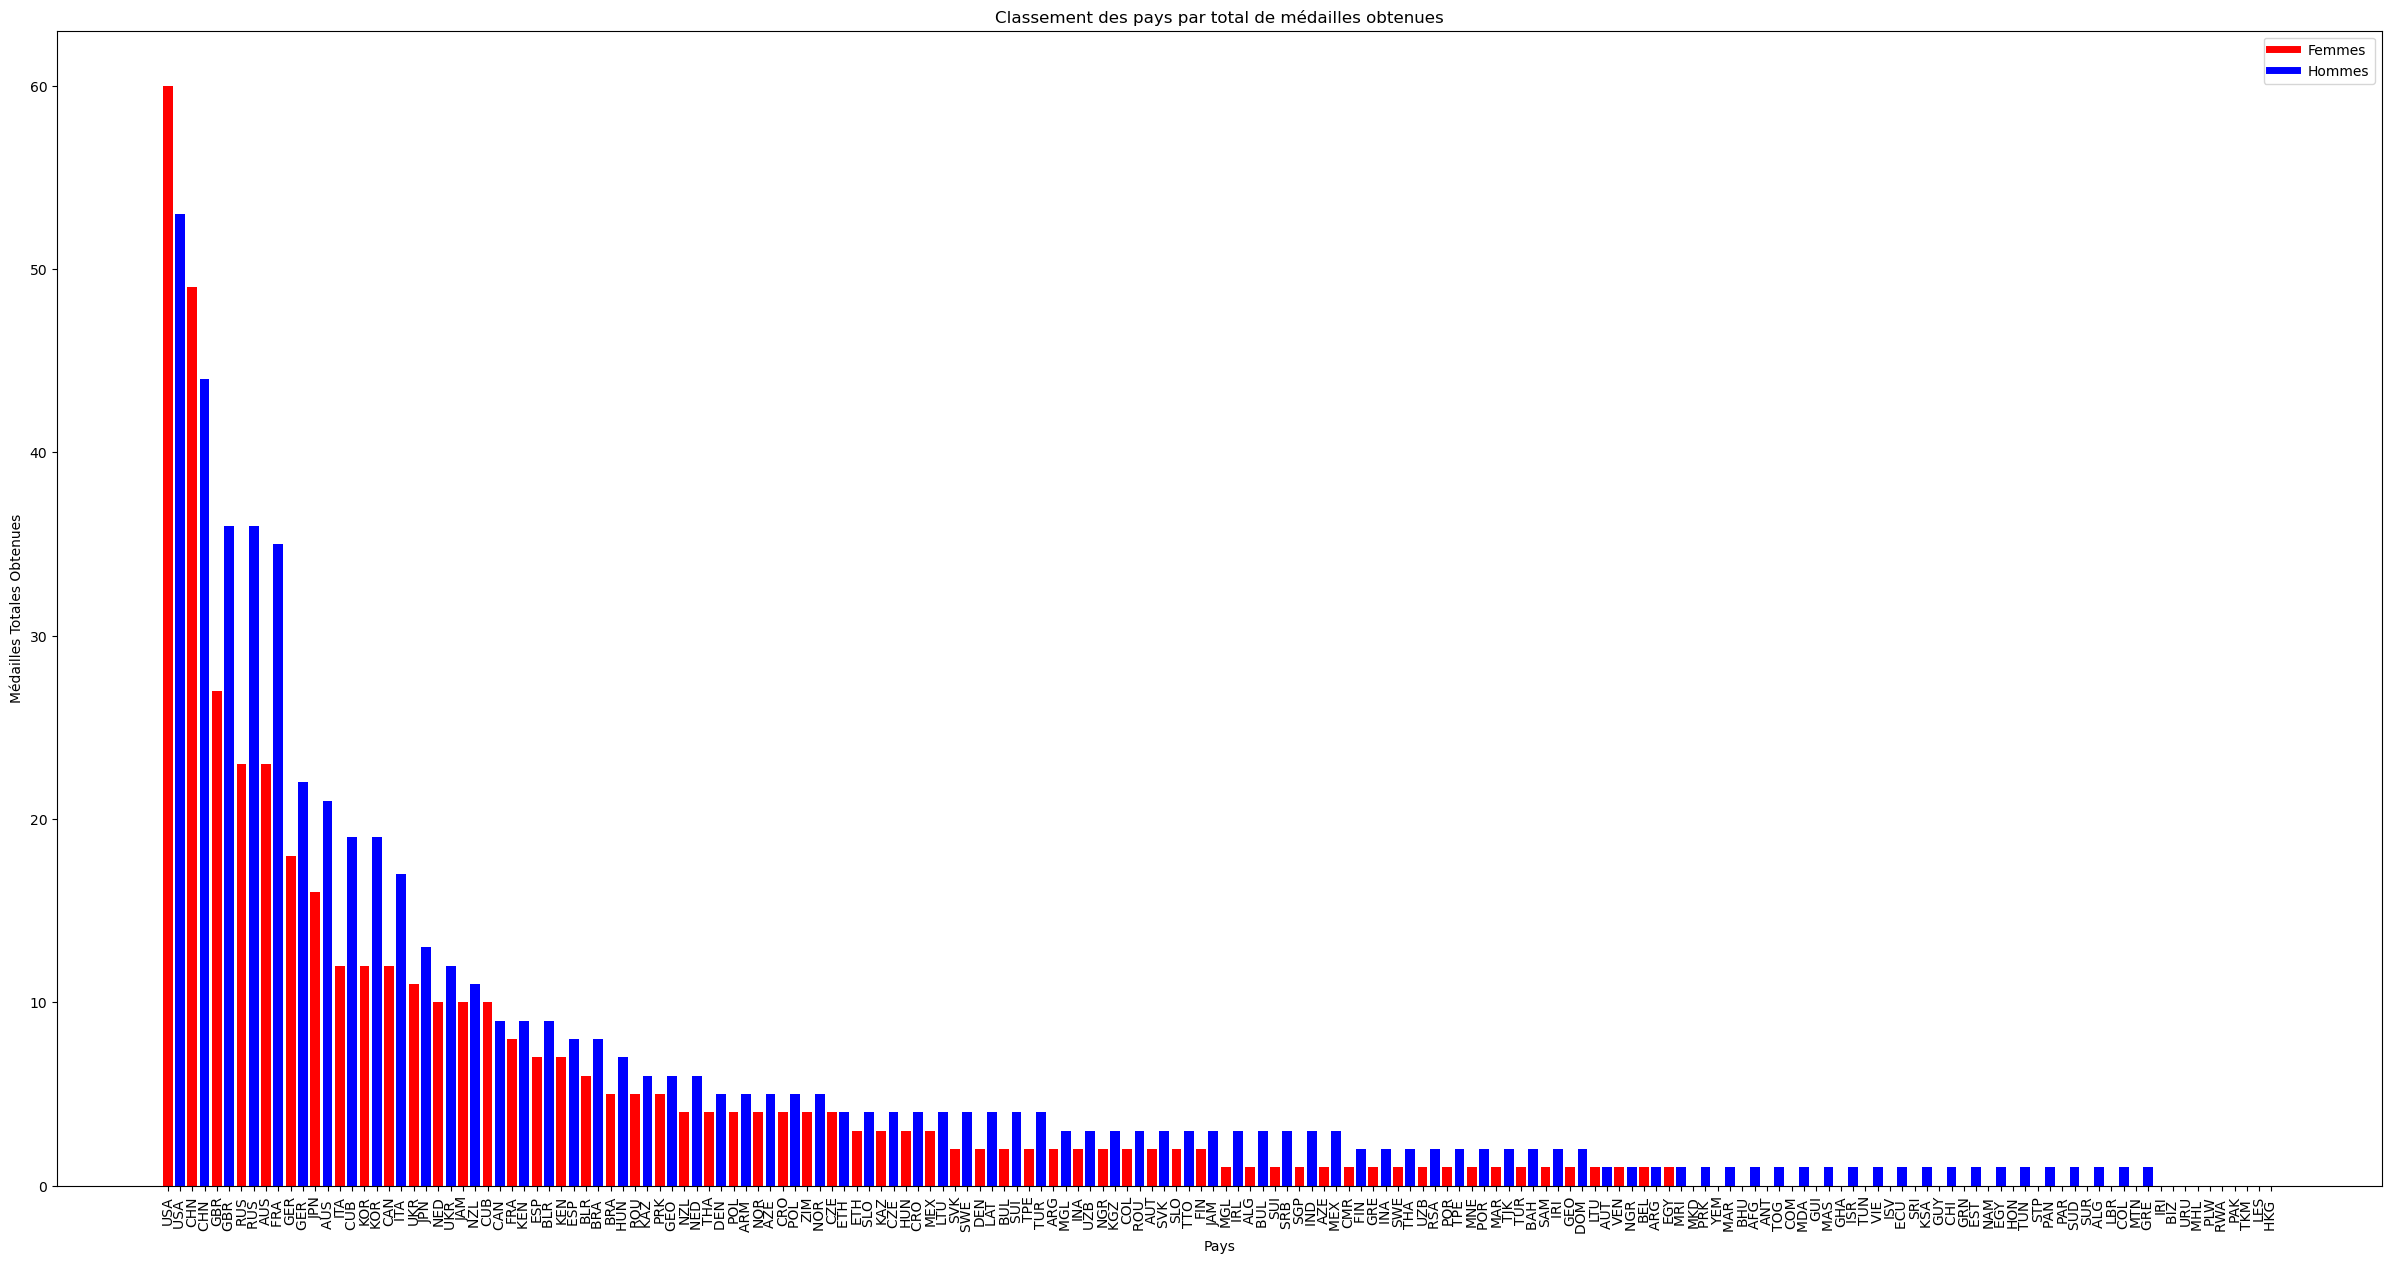

In [21]:
tabTotalFemmes= requete_vers_dataframe(conn,f"""SELECT * FROM {SCHEMA}.MEDAILLES_NOC_GENRE_2012 WHERE GENRE ='Female' ORDER BY TOTAL_MEDAILLES DESC""")
tabTotalHommes= requete_vers_dataframe(conn,f"""SELECT * FROM {SCHEMA}.MEDAILLES_NOC_GENRE_2012 WHERE GENRE ='Male' ORDER BY TOTAL_MEDAILLES DESC""")

nbPays = requete_vers_dataframe(conn, f"""
    SELECT COUNT(*) FROM {SCHEMA}.MEDAILLES_NOC_2012 WHERE TOTAL_MEDAILLES != 0
""").iloc[0,0]


nocs = []
nbMed = []
couleur=[]

for i in range(nbPays):
    paysF = tabTotalFemmes.iloc[i]
    paysH = tabTotalHommes.iloc[i]
    nocs.append(paysF['CODENOC'])
    nbMed.append(paysF['TOTAL_MEDAILLES'])
    couleur.append('red')
    nocs.append(paysH['CODENOC']+ " ")
    nbMed.append(paysH['TOTAL_MEDAILLES'])
    couleur.append('blue')

plt.figure(figsize=((30, 15)))
plt.bar(nocs, nbMed, color=couleur)
plt.xlabel('Pays')
plt.ylabel('Médailles Totales Obtenues')
plt.title('Classement des pays par total de médailles obtenues')
plt.xticks(rotation=90) 
legend_elements = [Line2D([0], [0], color='red', lw=5, label='Femmes'),
                   Line2D([0], [0], color='blue', lw=5, label='Hommes')]
plt.legend(handles=legend_elements, loc='upper right')
plt.show()

Ce graphique met cote à cote les medailles obtenues par les hommes et femmes d'un meme pays, avec en rouge les medailles obtenues par les femmes et en bleu celles obtenues par les hommes.
On remarque que dans les pays ayant remporté le plus de médailles (USA et Chine), une large majorité de des médailles est remportée par des femmes tandis que dans les autres pays les hommes gagnent plus de compétitions que leurs coéquipières.
Cette répartition nous indique une grande domination des USA et de la Chine dans les épreuves féminines pour diverses raisons. Nous pouvous néanmoins conclure de ce graphique que les premières places des épreuves sont réalisées par des pays plus divers dans les épreuves masculines que dans les épreuves féminines.

### - Nombre d'Athletes Par Pays et par genre sur l'entièreté des JO
## Attention, les cellules peuvent prendre du temps à s'executer

In [30]:
def AthletesParPaysBarres(seuil_athletes):
    tabTotalFemmes = requete_vers_dataframe(conn, f"""SELECT * FROM NBATHLGENRENATION WHERE GENRE ='Female' """)
    tabTotalHommes = requete_vers_dataframe(conn, f"""SELECT * FROM NBATHLGENRENATION WHERE GENRE ='Male' """)

    # On choisit de ne pas montrer les pays qui ont le moins d'athlètes
    nbPays = requete_vers_dataframe(conn, f"""
        SELECT COUNT(DISTINCT NOC) FROM NBATHLGENRENATION WHERE TOTAL_ATHLETES > {seuil_athletes}
    """).iloc[0, 0]

    nocs = []
    nbAthletes = []
    couleur = []

    # Assurez-vous que les deux DataFrames ont le même nombre de lignes, sinon bouclez jusqu'au plus petit nombre
    for i in range(min(len(tabTotalFemmes), len(tabTotalHommes))):
        paysF = tabTotalFemmes.iloc[i]
        paysH = tabTotalHommes.iloc[i]
        #On vérfie si un des deux a dépassé le seuil, si c'est le cas on quitte la boucle 
        #pour éviter d'afficher un genre sans l'autre
        if paysF['TOTAL_ATHLETES'] <seuil_athletes or paysH['TOTAL_ATHLETES']<seuil_athletes: break
#        if paysF['TOTAL_ATHLETES'] > seuil_athletes and paysF['NOC']:
 #           nocs.append(paysF['NOC'] + " F")
 #           nbAthletes.append(paysF['TOTAL_ATHLETES'])
 #           couleur.append('red')
            
        if paysH['TOTAL_ATHLETES'] > seuil_athletes and paysH['NOC']:
            Ftemp = requete_vers_dataframe(conn, f"""SELECT * FROM NBATHLGENRENATION WHERE GENRE ='Female' AND NOC='{paysH['NOC']}' """).iloc[0]
            nocs.append(Ftemp['NOC'] + " F")
            nbAthletes.append(Ftemp['TOTAL_ATHLETES'])
            couleur.append('red')
            nocs.append(paysH['NOC'] + " H")
            nbAthletes.append(paysH['TOTAL_ATHLETES'])
            couleur.append('blue')

    # Ajuster la taille de la figure en fonction du nombre de pays
    figsize = (max(10, len(nocs) * 0.5), 15)

    plt.figure(figsize=figsize)
    plt.bar(nocs, nbAthletes, color=couleur)
    plt.xlabel('Pays')
    plt.ylabel("Nombre d'Athlètes")
    plt.title("Classement des pays par nombre d'Athlètes envoyés aux JO")
    plt.xticks(rotation=90)

    # Ajouter une légende
    legend_elements = [Line2D([0], [0], color='red', lw=4, label='Femmes'),
                       Line2D([0], [0], color='blue', lw=4, label='Hommes')]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.show()
    
    
    
    
def AthletesParPaysBarresAnnee(annee,seuil_athletes):
    tabTotalFemmes = requete_vers_dataframe(conn, f""" select an.noc,genre,count(distinct an.idAthlete) as TOTAL_ATHLETES from AthleteNationalite an 
            inner join athlete a on an.idAthlete=a.idAthlete
            LEFT JOIN composition_equipe ce ON ce.idAthlete = a.idAthlete
            INNER JOIN participation_individuelle pi ON pi.idAthlete = a.idAthlete
            INNER JOIN evenement e ON e.idEvenement = pi.idEvent
            INNER JOIN hote h ON h.idHote = e.idHote
            WHERE h.libelleHote = '{annee} Summer Olympics' and genre='Female'
            group by an.noc,genre
            order by "TOTAL_ATHLETES" DESC """)
    tabTotalHommes = requete_vers_dataframe(conn, f"""select an.noc,genre,count(distinct an.idAthlete) as "TOTAL_ATHLETES" from AthleteNationalite an 
            inner join athlete a on an.idAthlete=a.idAthlete
            LEFT JOIN composition_equipe ce ON ce.idAthlete = a.idAthlete
            INNER JOIN participation_individuelle pi ON pi.idAthlete = a.idAthlete
            INNER JOIN evenement e ON e.idEvenement = pi.idEvent
            INNER JOIN hote h ON h.idHote = e.idHote
            WHERE h.libelleHote = '{annee} Summer Olympics' and genre='Male'
            group by an.noc,genre
            order by "TOTAL_ATHLETES" DESC""")

    # On choisit de ne pas montrer les pays qui ont le moins d'athlètes
    nbPays = requete_vers_dataframe(conn, f"""
        SELECT COUNT(DISTINCT NOC) FROM NBATHLGENRENATION WHERE TOTAL_ATHLETES > {seuil_athletes}
    """).iloc[0, 0]

    nocs = []
    nbAthletes = []
    couleur = []

    # Assurez-vous que les deux DataFrames ont le même nombre de lignes, sinon bouclez jusqu'au plus petit nombre
    for i in range(min(len(tabTotalFemmes), len(tabTotalHommes))):
        paysF = tabTotalFemmes.iloc[i]
        paysH = tabTotalHommes.iloc[i]
        #On vérfie si un des deux a dépassé le seuil, si c'est le cas on quitte la boucle 
        #pour éviter d'afficher un genre sans l'autre
        if paysF['TOTAL_ATHLETES'] <seuil_athletes or paysH['TOTAL_ATHLETES']<seuil_athletes: break
#        if paysF['TOTAL_ATHLETES'] > seuil_athletes and paysF['NOC']:
 #           nocs.append(paysF['NOC'] + " F")
 #           nbAthletes.append(paysF['TOTAL_ATHLETES'])
 #           couleur.append('red')
            
        if paysH['TOTAL_ATHLETES'] > seuil_athletes and paysH['NOC']:
            Ftemp = requete_vers_dataframe(conn, f"""
                SELECT an.noc, genre, COUNT(DISTINCT an.idAthlete) AS "TOTAL_ATHLETES"
                FROM AthleteNationalite an 
                INNER JOIN athlete a ON an.idAthlete = a.idAthlete
                LEFT JOIN composition_equipe ce ON ce.idAthlete = a.idAthlete
                INNER JOIN participation_individuelle pi ON pi.idAthlete = a.idAthlete
                INNER JOIN evenement e ON e.idEvenement = pi.idEvent
                INNER JOIN hote h ON h.idHote = e.idHote
                WHERE h.libelleHote = '{annee} Summer Olympics' AND genre = 'Female' AND an.noc = '{paysH['NOC']}'
                GROUP BY an.noc, genre
                ORDER BY "TOTAL_ATHLETES" DESC
            """).iloc[0]
            nocs.append(Ftemp['NOC'] + " F")
            nbAthletes.append(Ftemp['TOTAL_ATHLETES'])
            couleur.append('red')
            nocs.append(paysH['NOC'] + " H")
            nbAthletes.append(paysH['TOTAL_ATHLETES'])
            couleur.append('blue')

    # Ajuster la taille de la figure en fonction du nombre de pays
    figsize = (max(10, len(nocs) * 0.5), 15)

    plt.figure(figsize=figsize)
    plt.bar(nocs, nbAthletes, color=couleur)
    plt.xlabel('Pays')
    plt.ylabel("Nombre d'Athlètes")
    plt.title("Classement des pays par nombre d'Athlètes envoyés aux JO")
    plt.xticks(rotation=90)

    # Ajouter une légende
    legend_elements = [Line2D([0], [0], color='red', lw=4, label='Femmes'),
                       Line2D([0], [0], color='blue', lw=4, label='Hommes')]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.show()


def AthletesParPaysPoints(seuil_athletes):
    tabTotalFemmes = requete_vers_dataframe(conn, f"""SELECT * FROM NBATHLGENRENATION WHERE GENRE ='Female' """)
    tabTotalHommes = requete_vers_dataframe(conn, f"""SELECT * FROM NBATHLGENRENATION WHERE GENRE ='Male' """)

    # On choisit de ne pas montrer les pays qui ont le moins d'athlètes
    nbPays = requete_vers_dataframe(conn, f"""
        SELECT COUNT(DISTINCT NOC) FROM NBATHLGENRENATION WHERE TOTAL_ATHLETES > {seuil_athletes}
    """).iloc[0, 0]

    nocs = []
    nbAthletes = []
    couleur = []

    # Assurez-vous que les deux DataFrames ont le même nombre de lignes, sinon bouclez jusqu'au plus petit nombre
    for i in range(min(len(tabTotalFemmes), len(tabTotalHommes))):
        paysF = tabTotalFemmes.iloc[i]
        paysH = tabTotalHommes.iloc[i]
        if paysF['TOTAL_ATHLETES'] <seuil_athletes or paysH['TOTAL_ATHLETES']<seuil_athletes: break
#        if paysF['TOTAL_ATHLETES'] > seuil_athletes and paysF['NOC']:
#            nocs.append(paysF['NOC'] + " F")
#            nbAthletes.append(paysF['TOTAL_ATHLETES'])
  #          couleur.append('red')
            
        if paysH['TOTAL_ATHLETES'] > seuil_athletes and paysH['NOC']:
            Ftemp = requete_vers_dataframe(conn, f"""SELECT * FROM NBATHLGENRENATION WHERE GENRE ='Female' AND NOC='{paysH['NOC']}' """).iloc[0]
            nocs.append(Ftemp['NOC'] + " F")
            nbAthletes.append(Ftemp['TOTAL_ATHLETES'])
            couleur.append('red')
            nocs.append(paysH['NOC'] + " H")
            nbAthletes.append(paysH['TOTAL_ATHLETES'])
            couleur.append('blue')

    # Ajuster la taille de la figure en fonction du nombre de pays
    figsize = (max(10, len(nocs) * 0.5), 15)

    plt.figure(figsize=figsize)
    for i in range(len(nocs)):
        plt.scatter(nocs[i], nbAthletes[i], color=couleur[i], label=nocs[i])
    
    plt.xlabel('Pays')
    plt.ylabel("Nombre d'Athlètes")
    plt.title("Classement des pays par nombre d'Athlètes envoyés aux JO")
    plt.xticks(rotation=90)

    # Ajouter une légende
    legend_elements = [Line2D([0], [0], color='red', lw=4, label='Femmes'),
                       Line2D([0], [0], color='blue', lw=4, label='Hommes')]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.show()

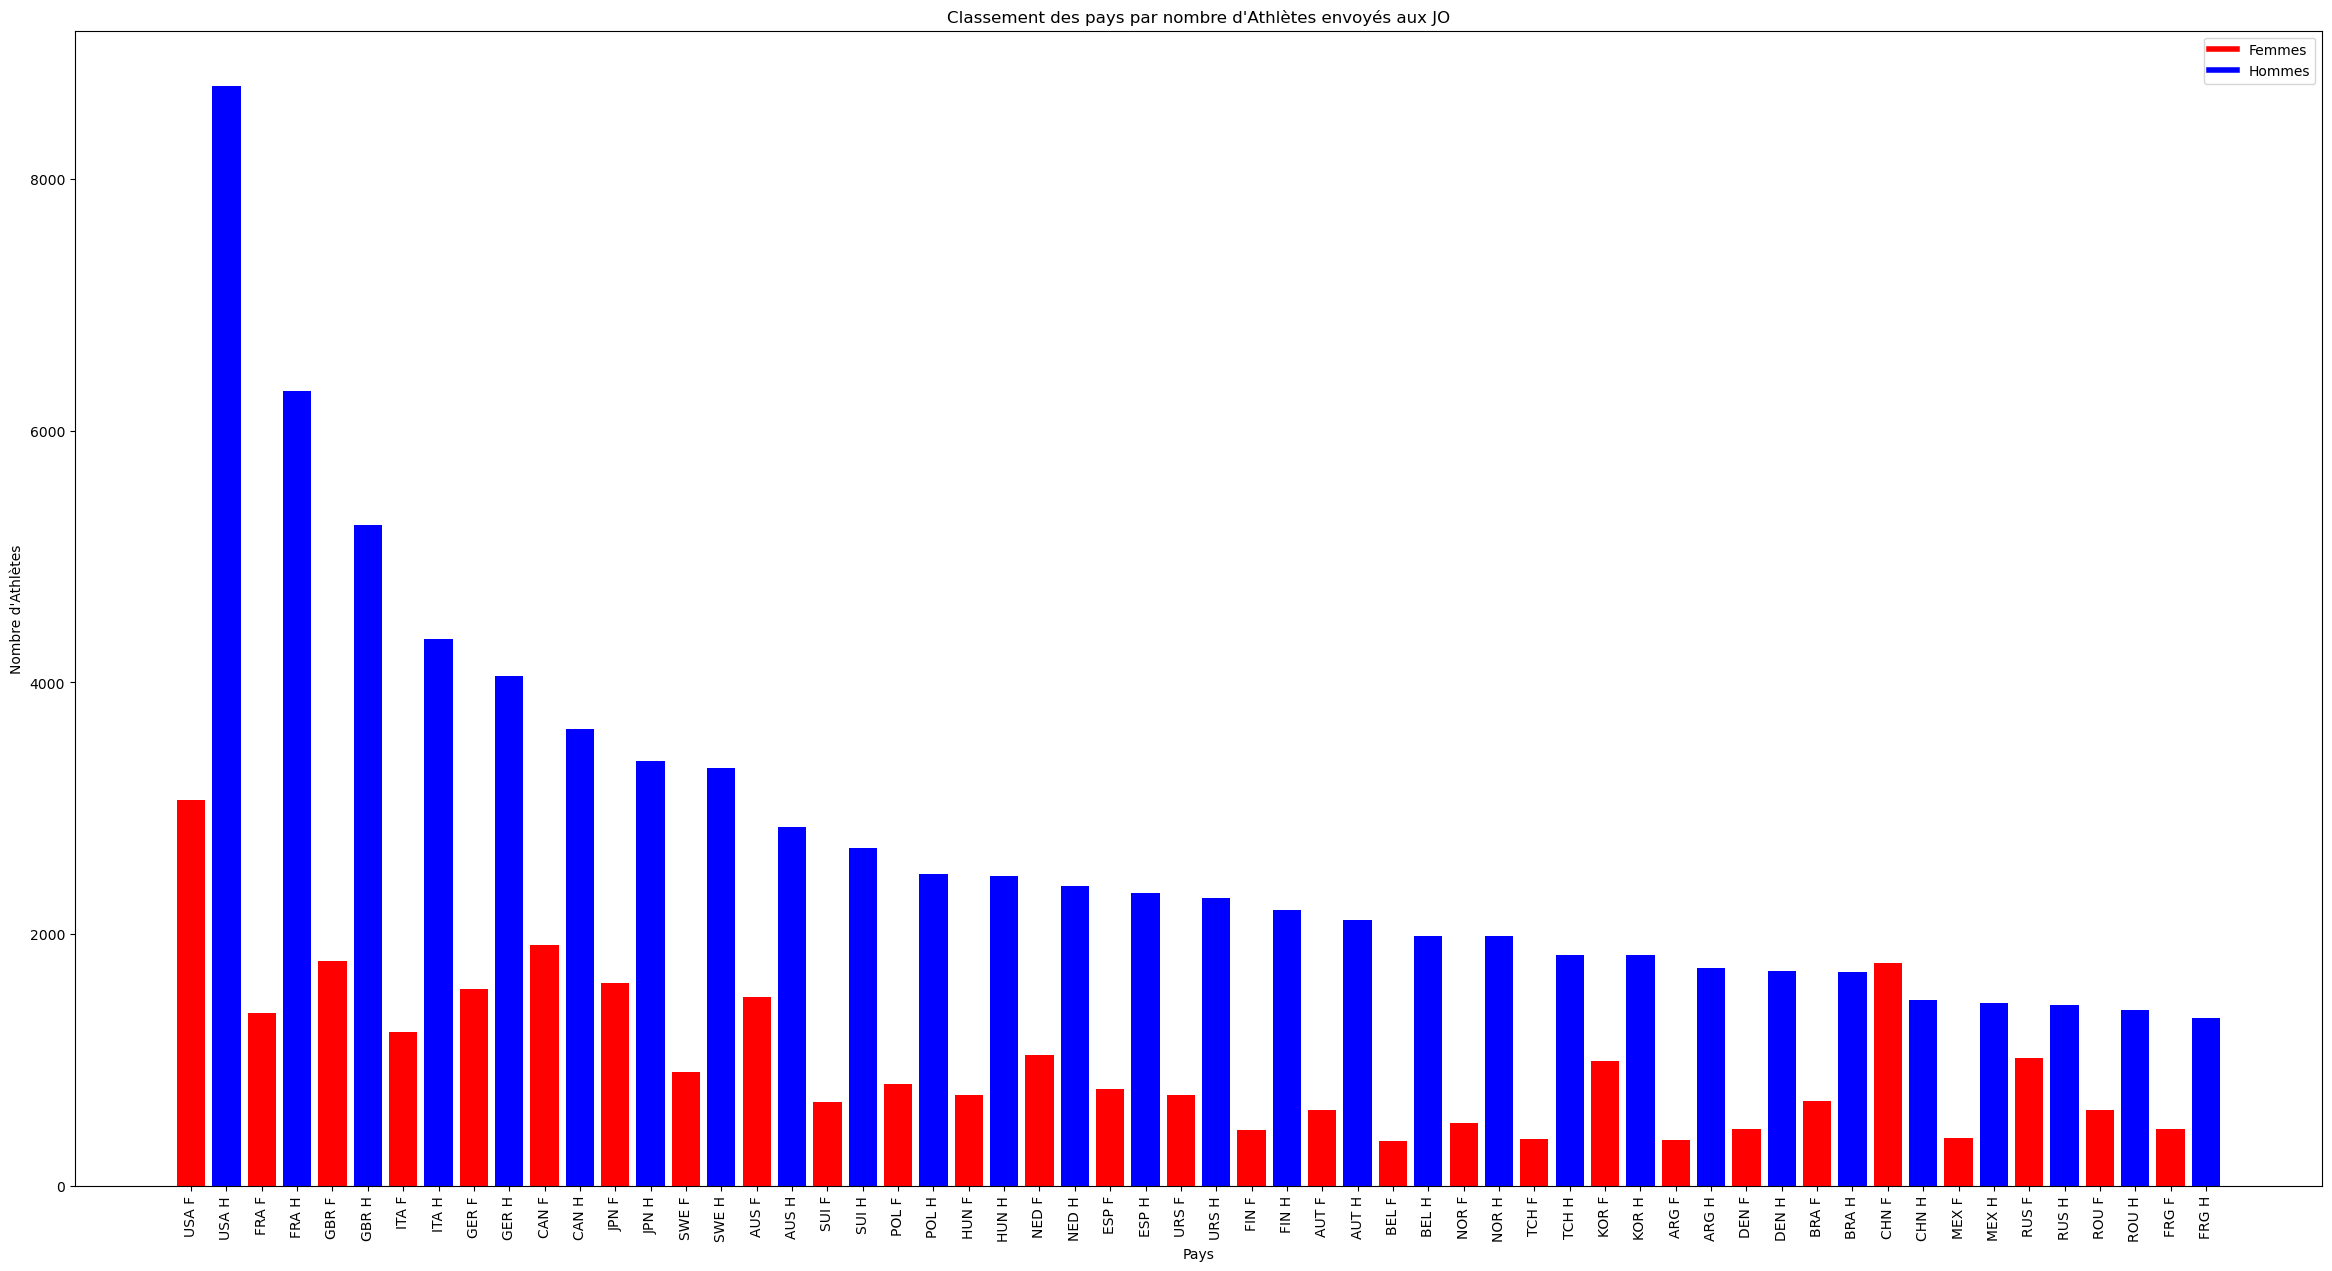

In [31]:
AthletesParPaysBarres(400) #Nombre et pays affiché que a partir de 500 athletes dans une catégorie
#On peut réaliser l'appel qu'on veut pour augmenter ou diminuer la précision du graphique,
#il deviendra néanmoins moins lisible a moins d'avoir de quoi le grossir

 - Vue en points qui permet de mieux voir avec un seuil plus petit (on perd la lecture de la légende néanmoins)

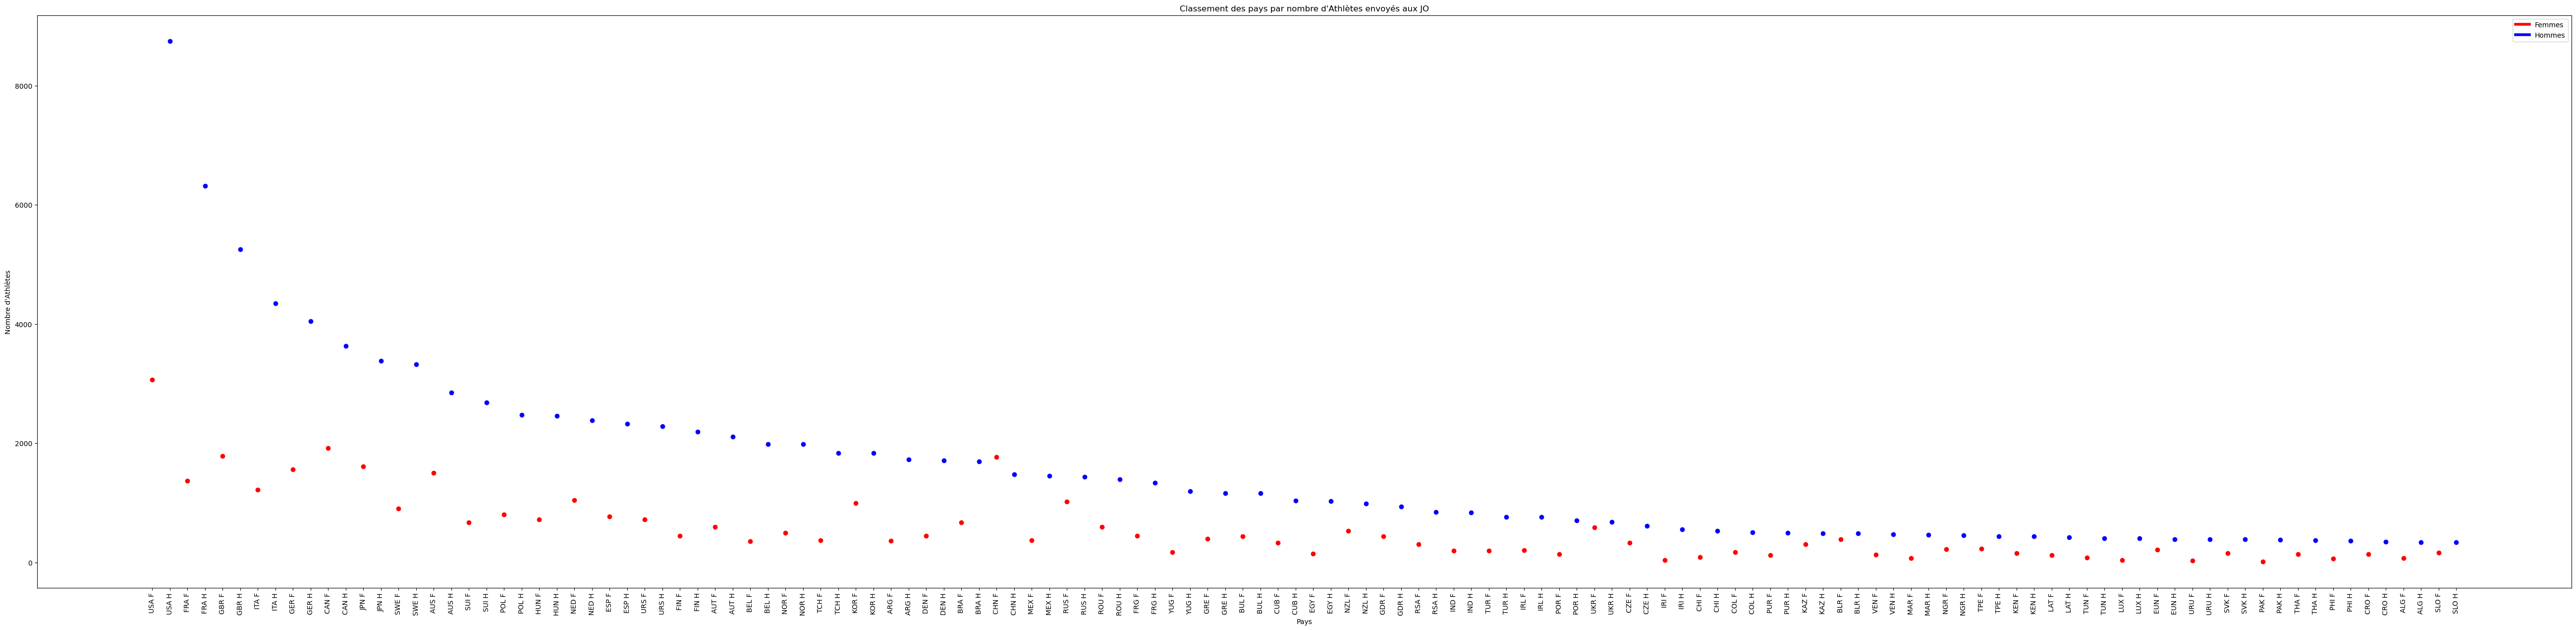

In [32]:
AthletesParPaysPoints(100)

Comme le montrent les deux graphiques ci dessus, depuis le début des JO modernes, il y a une écrasante majorité de pays qui ont pour l'instant fait participer significativement plus de compétiteurs que de compétitrices.
Tous les pays suivent cette règle...  Tous ? Non ! Un pays d'irréductibles compétitrices résiste encore et toujours. 
En effet la Chine est le seul pays qui lors de JO 2012 a envoyé une majorité d'athlètes féminins, ce qui peut expliquer leur succès dans les épreuves féminines. 
Il est notable que certains pays s'approchent petit a petit de l'égalité des genres comme la Corée, l'Australie ou encore le Canada,  mais ces exemples restent minoritaires.

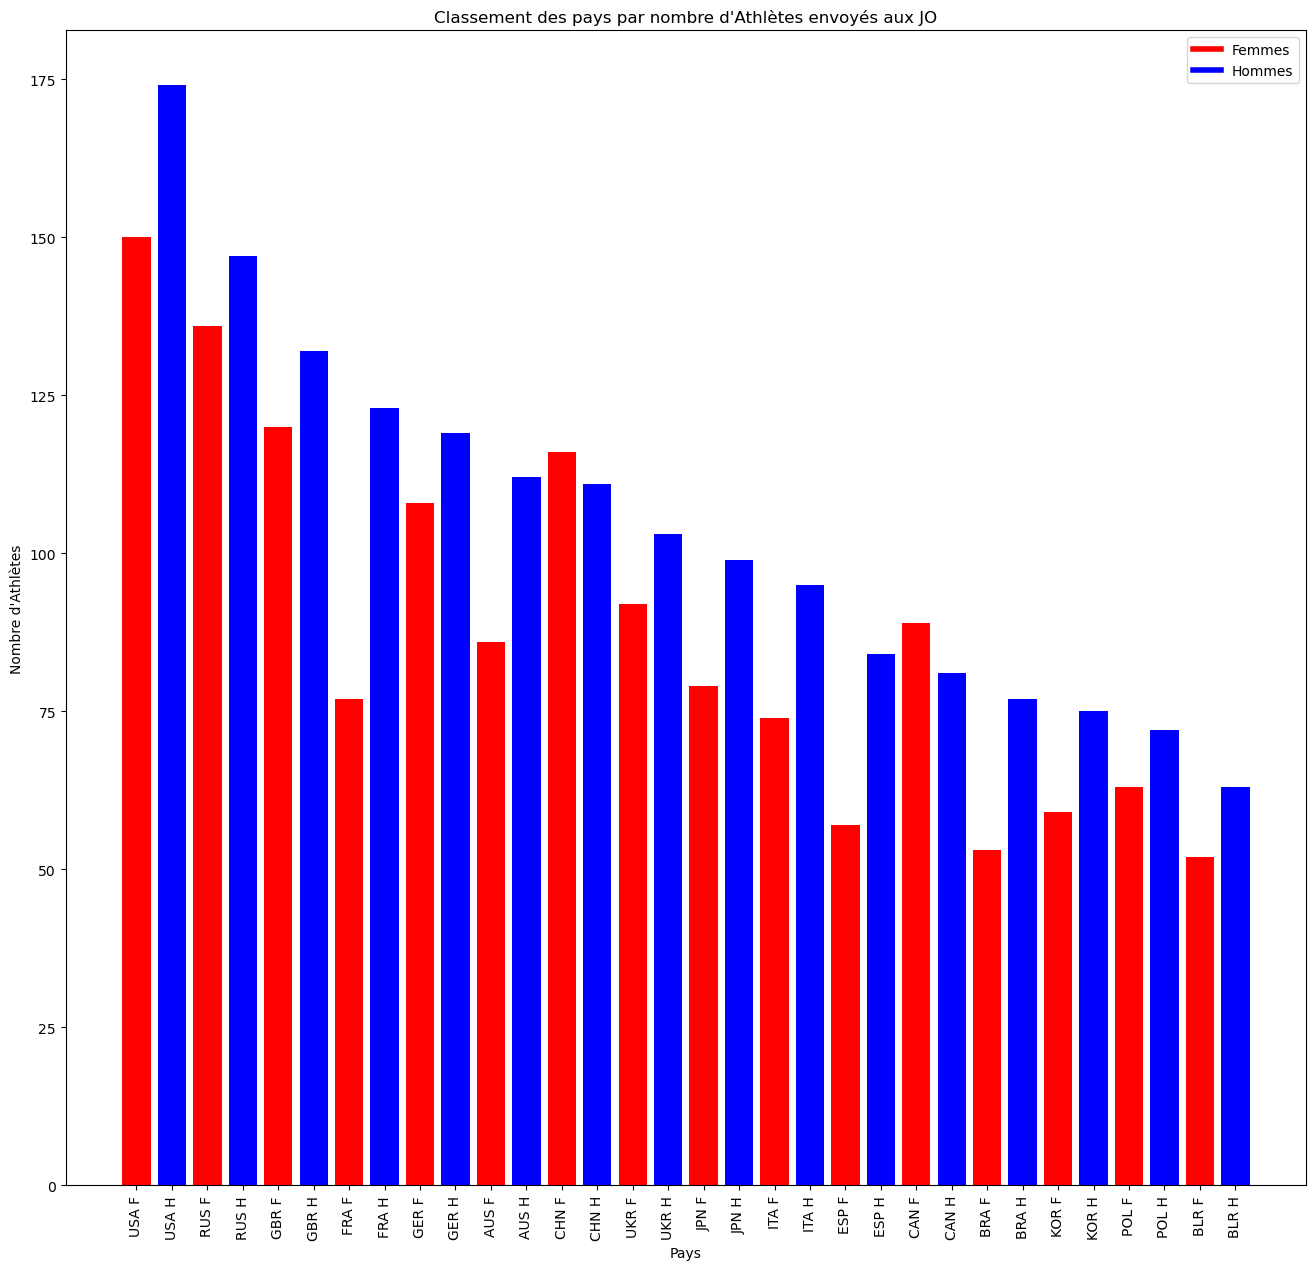

In [33]:
AthletesParPaysBarresAnnee('2012',50)

Ci-dessus est la répartition homme/femme par pays en 2012 uniquement cette fois ci, on voit qu'avec le temps le nombre de compétitrices augmente grandement (phénomène qu'on observera plus tard dans le rapport), et que la Chine n'est plus le seul pays à avoir une majorité d'athlètes femme.

### Evolution des performances du top 3 des pays

In [34]:
def afficherEvolutionPerfs(data, nomNoc):
    # Extraction des années et des valeurs
    years = [row[0] for row in data]
    medailles_bronze = [row[1] for row in data]
    medailles_argent = [row[2] for row in data]
    medailles_or = [row[3] for row in data]
    medailles_total = [row[4] for row in data]

    # Création du graphique
    plt.figure(figsize=(12, 6))
    plt.plot(years, medailles_bronze, label='Bronze', color='#A77044')
    plt.plot(years, medailles_argent, label='Argent', color='#A7A7AD')
    plt.plot(years, medailles_or, label='Or', color='#D6AF36')
    plt.plot(years, medailles_total, label='Total', color='r')

    # Ajout des légendes et des titres
    plt.xlabel('Année')
    plt.ylabel('Nombre de médailles')
    plt.title('Médailles par année : '+ nomNoc)
    plt.legend()

    # Affichage du graphique
    plt.grid(True)
    plt.show()
    

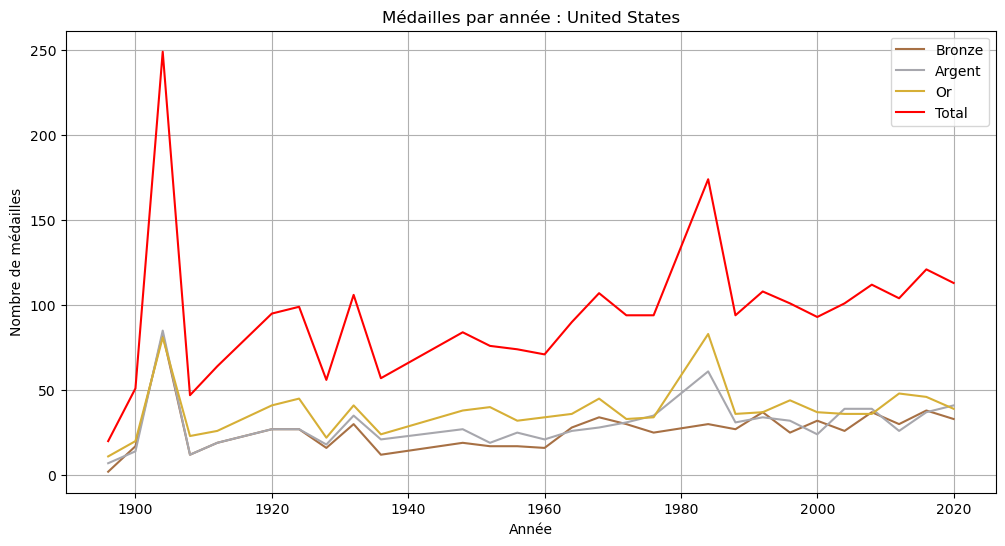

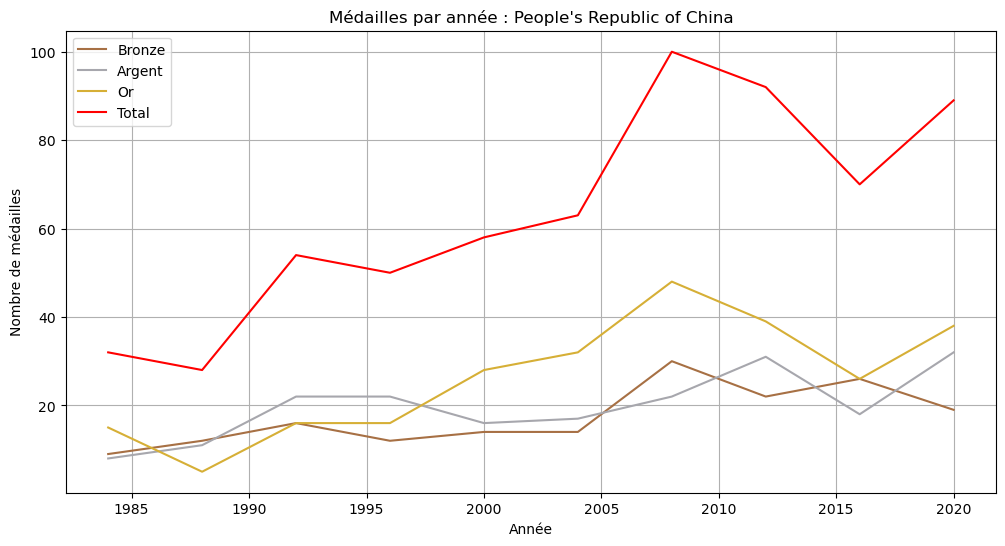

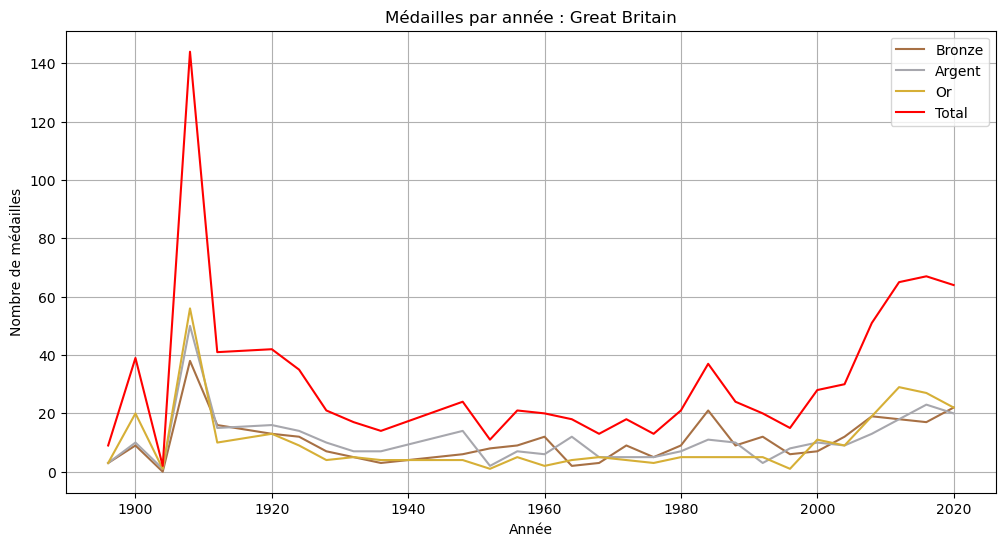

In [35]:
with Connexion(login=conn['login'], password=conn['password']) as connexion:  # Démarre une nouvelle connexion

    connexion.begin()
    curseur = connexion.cursor()
    #### top 3 
    curseur.execute(f"SELECT CODENOC, NOMNOC FROM {SCHEMA}.MEDAILLES_NOC_HOTES WHERE idHote={id_hote} FETCH FIRST 3 ROWS ONLY")
    top_3_equipes = curseur.fetchall()  # Renvoie un tuple, on veut le premier élément du tuple
    for noc in top_3_equipes:
        codeNoc = noc[0]
        nomNoc = noc[1]
        curseur.execute(f"""SELECT ANNEEHOTE, medaillesBronze, medaillesArgent, medaillesOr, totalMedailles  FROM MEDAILLES_NOC_HOTES
        natural JOIN HOTE WHERE CODENOC
        ='{codeNoc}'
        AND SAISON='Summer'
      GROUP BY CODENOC, ANNEEHOTE, medaillesBronze, medaillesArgent, medaillesOr, totalMedailles ORDER BY ANNEEHOTE ASC""")
        data_noc_perfs = curseur.fetchall()
        afficherEvolutionPerfs(data_noc_perfs, nomNoc) 

#### Evolution de la taille des Athlètes par genre au fil du temps

In [41]:

def tracerTailleMoyenneParEdition():
    requete = """
    -- Taille moyenne par édition, genre (équipe et individuelle)
    SELECT h.anneeHote AS annee, h.libellehote AS edition, a.genre AS genre, 'Individuelle' AS type_competition, round(AVG(a.taille), 1) AS taille_moyenne
    FROM participation_individuelle pi
    INNER JOIN athlete a ON pi.idathlete = a.idathlete
    INNER JOIN evenement e ON pi.idevent = e.idevenement
    INNER JOIN hote h ON e.idhote = h.idhote
    WHERE a.taille IS NOT NULL AND h.saison = 'Summer'
    GROUP BY h.anneeHote, h.libellehote, a.genre

    UNION ALL

    SELECT h.anneeHote AS annee, h.libellehote AS edition, a.genre AS genre, 'Équipe' AS type_competition, round(AVG(a.taille), 1) AS taille_moyenne
    FROM participation_equipe pe
    INNER JOIN composition_equipe ce ON pe.idequipe = ce.idequipe
    INNER JOIN athlete a ON ce.idathlete = a.idathlete
    INNER JOIN evenement e ON pe.idevenement = e.idevenement
    INNER JOIN hote h ON e.idhote = h.idhote
    WHERE a.taille IS NOT NULL AND h.saison = 'Summer'
    GROUP BY h.anneeHote, h.libellehote, a.genre
    ORDER BY annee, genre
    """
    
    df = requete_vers_dataframe(conn, requete)
    
    plt.figure(figsize=(16, 8))

    # Tracer les données pour les hommes et les femmes
    genres = df['GENRE'].unique()
    competitions = df['TYPE_COMPETITION'].unique()
    couleurs = {'Male': 'blue', 'Female': 'red'}
    marqueurs = {'Individuelle': 'o', 'Équipe': 's'}
    line_styles = {'Individuelle': '--', 'Équipe': '-.'}
    edge_colors = {'Individuelle': 'black', 'Équipe': 'black'}
    
    for genre in genres:
        for competition in competitions:
            donneesCompetition = df[(df['GENRE'] == genre) & (df['TYPE_COMPETITION'] == competition)]
            plt.plot(donneesCompetition['ANNEE'], donneesCompetition['TAILLE_MOYENNE'], 
                     label=f"{genre} ({competition})", color=couleurs[genre], marker=marqueurs[competition],
                     markersize=10, linewidth=3, linestyle=line_styles[competition])

            plt.scatter(donneesCompetition['ANNEE'], donneesCompetition['TAILLE_MOYENNE'], 
                        color=couleurs[genre], s=100, edgecolor=edge_colors[competition], linewidth=1, zorder=5)
            
            for i in range(len(donneesCompetition)):
                plt.annotate(int(donneesCompetition['TAILLE_MOYENNE'].iloc[i]), 
                             (donneesCompetition['ANNEE'].iloc[i], donneesCompetition['TAILLE_MOYENNE'].iloc[i]),
                             textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color='blue')
    
    plt.xlabel('Années', fontsize=14, fontweight='bold')
    plt.ylabel('Taille Moyenne (cm)', fontsize=14, fontweight='bold')
    plt.title('Taille Moyenne des Athlètes par Édition des JO (Été)', fontsize=18, fontweight='bold', color='#3333A8')
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
    plt.gca().patch.set_facecolor('#f0f0f0')
    
    plt.legend(loc='upper left', fontsize=12, frameon=True, shadow=True, borderpad=1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.show()


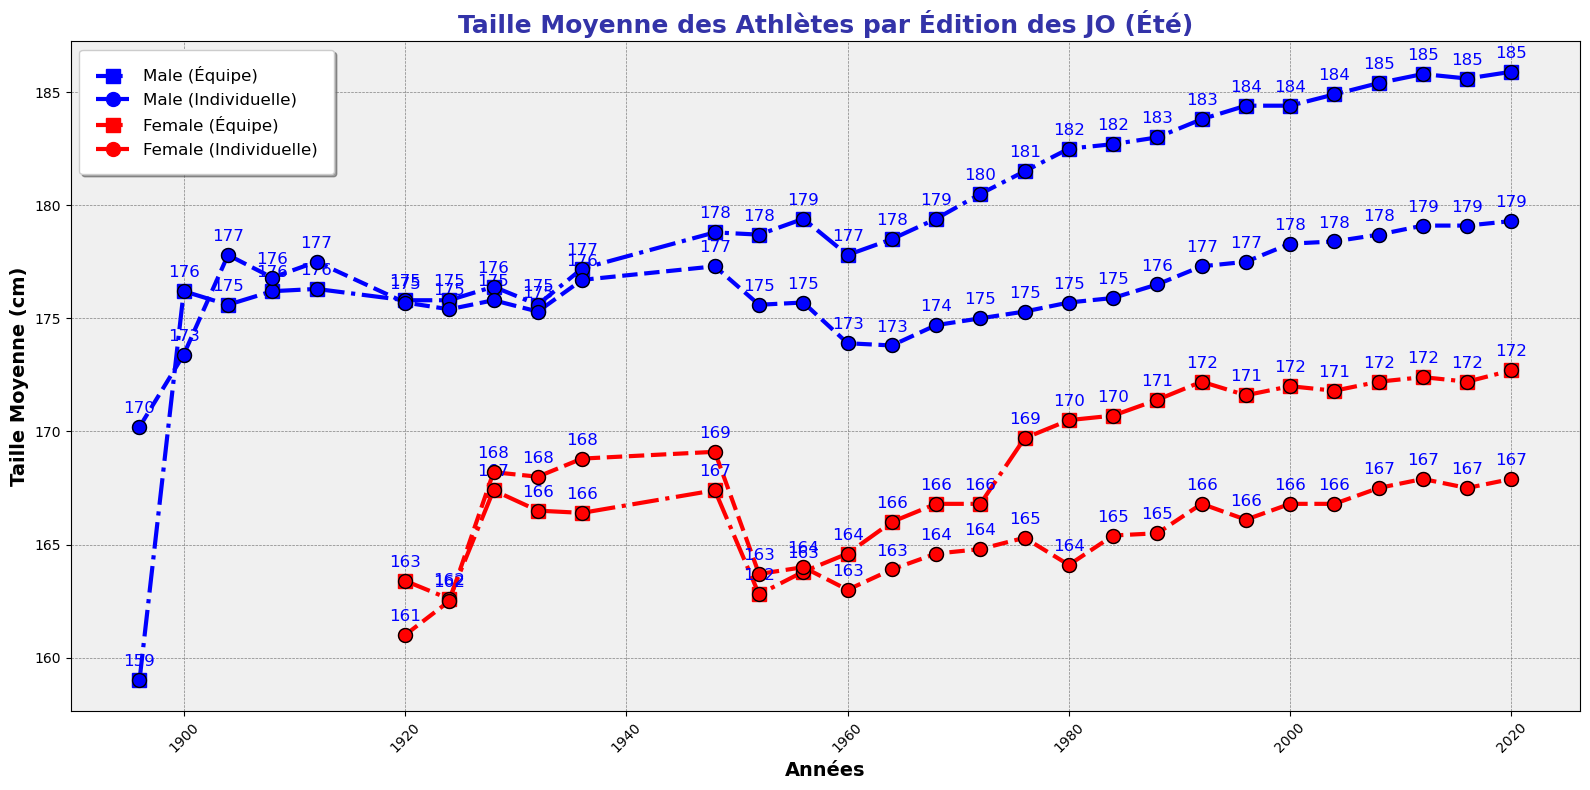

In [42]:
tracerTailleMoyenneParEdition()

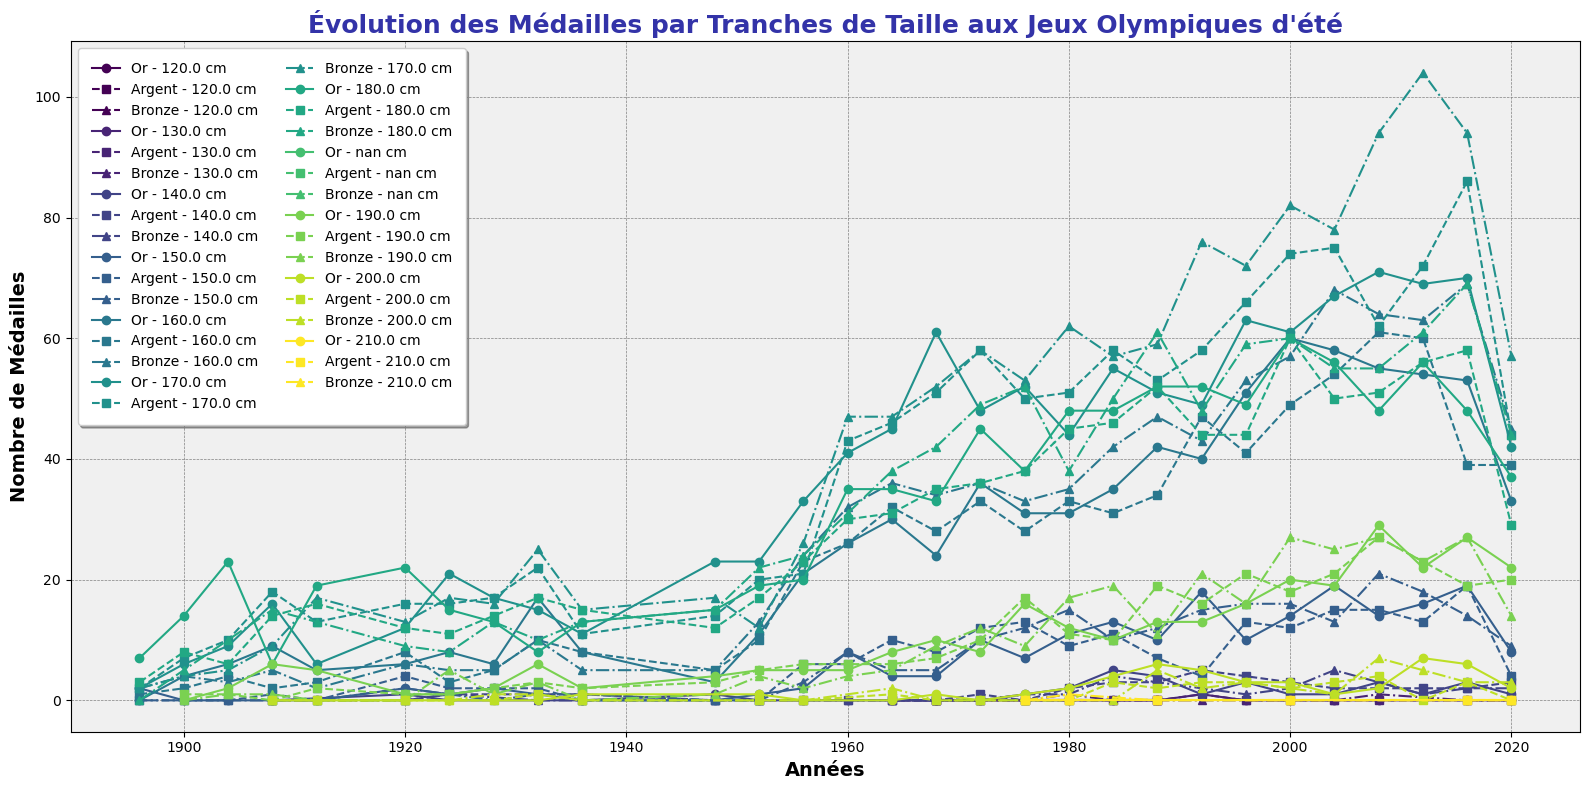

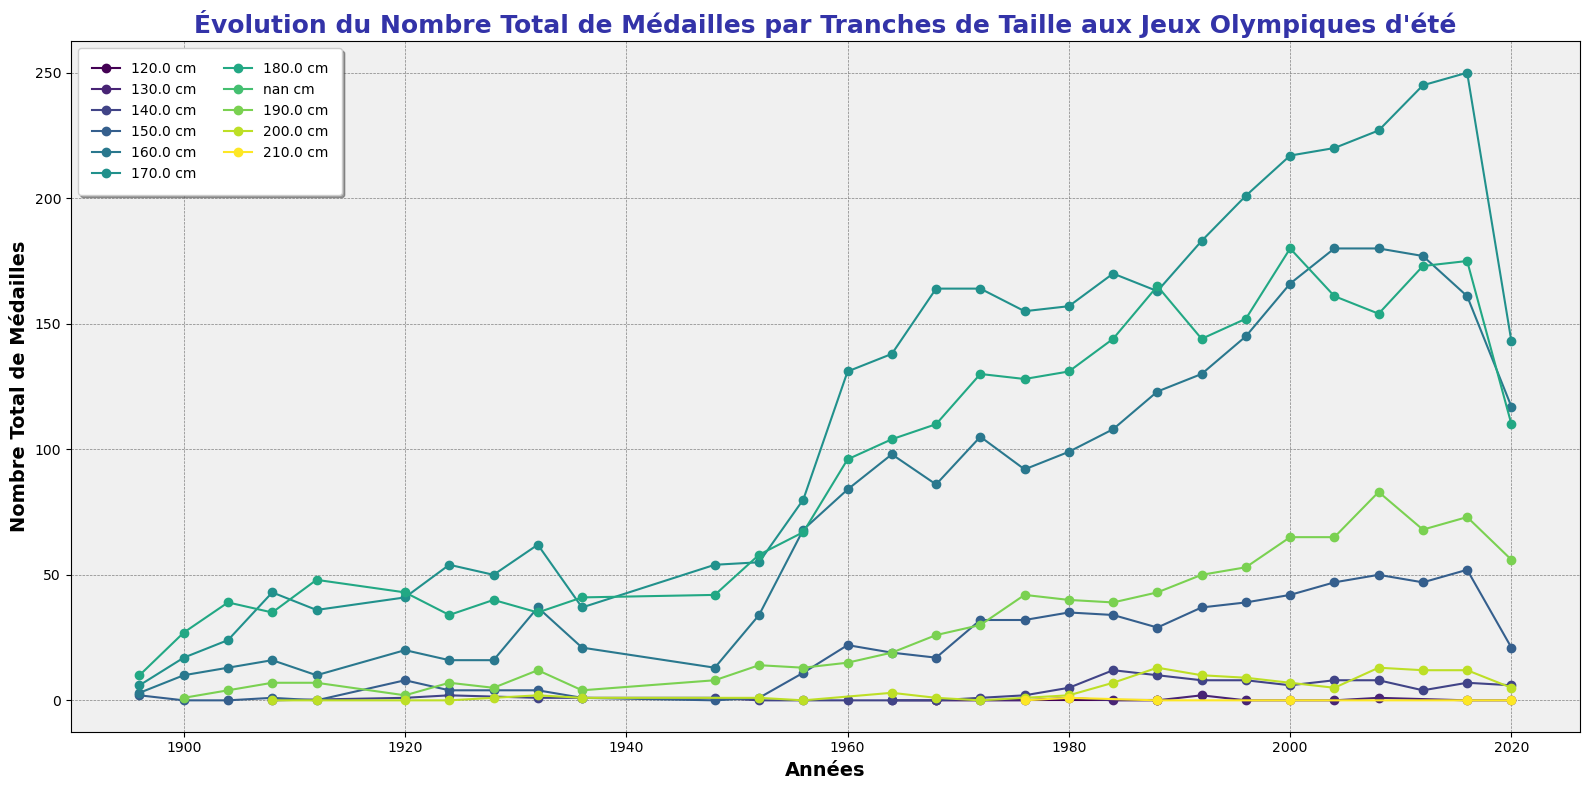

In [70]:
query = """
SELECT
    FLOOR(a.taille / 10) * 10 AS TAILLE_TRANCHE,
    h.libellehote,
    SUM(CASE WHEN pi.MEDAILLE = 'Gold' THEN 1 ELSE 0 END) AS OR_MEDAILLES,
    SUM(CASE WHEN pi.MEDAILLE = 'Silver' THEN 1 ELSE 0 END) AS ARGENT_MEDAILLES,
    SUM(CASE WHEN pi.MEDAILLE = 'Bronze' THEN 1 ELSE 0 END) AS BRONZE_MEDAILLES
FROM
    PARTICIPATION_INDIVIDUELLE pi
INNER JOIN 
    athlete a ON a.idathlete = pi.idathlete
INNER JOIN 
    evenement e ON e.idevenement = pi.idevent
INNER JOIN 
    hote h ON h.idhote = e.idhote
WHERE 
    h.libellehote LIKE '%Summer Olympics%'
GROUP BY
    FLOOR(a.taille / 10) * 10, h.libellehote
ORDER BY
    h.libellehote, TAILLE_TRANCHE
"""
tabMedaillesParTaille = requete_vers_dataframe(conn, query)


def extraire_annee(libellehote):
    match = re.search(r'(\d{4}) Summer Olympics', libellehote)
    return int(match.group(1)) if match else None


tabMedaillesParTaille['annee'] = tabMedaillesParTaille['LIBELLEHOTE'].apply(extraire_annee)


annees_exclues = [1916, 1940, 1944]
tabMedaillesParTaille = tabMedaillesParTaille[~tabMedaillesParTaille['annee'].isin(annees_exclues)]


plt.figure(figsize=(16, 8))


annees = tabMedaillesParTaille['annee'].unique()


tranches_taille = sorted(tabMedaillesParTaille['TAILLE_TRANCHE'].unique())


colors = plt.cm.viridis(np.linspace(0, 1, len(tranches_taille)))


for idx, tranche in enumerate(tranches_taille):
    tranche_data = tabMedaillesParTaille[tabMedaillesParTaille['TAILLE_TRANCHE'] == tranche]
    plt.plot(tranche_data['annee'], tranche_data['OR_MEDAILLES'], label=f'Or - {tranche} cm', color=colors[idx], marker='o', linestyle='-')
    plt.plot(tranche_data['annee'], tranche_data['ARGENT_MEDAILLES'], label=f'Argent - {tranche} cm', color=colors[idx], marker='s', linestyle='--')
    plt.plot(tranche_data['annee'], tranche_data['BRONZE_MEDAILLES'], label=f'Bronze - {tranche} cm', color=colors[idx], marker='^', linestyle='-.')


plt.xlabel('Années', fontsize=14, fontweight='bold')
plt.ylabel('Nombre de Médailles', fontsize=14, fontweight='bold')
plt.title('Évolution des Médailles par Tranches de Taille aux Jeux Olympiques d\'été', fontsize=18, fontweight='bold', color='#3333A8')


plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')


plt.gca().patch.set_facecolor('#f0f0f0')


plt.legend(loc='upper left', fontsize=10, frameon=True, shadow=True, borderpad=1, ncol=2)


plt.tight_layout()
plt.show()



query = """
SELECT
    FLOOR(a.taille / 10) * 10 AS TAILLE_TRANCHE,
    h.libellehote,
    SUM(CASE WHEN pi.MEDAILLE = 'Gold' THEN 1 ELSE 0 END +
        CASE WHEN pi.MEDAILLE = 'Silver' THEN 1 ELSE 0 END +
        CASE WHEN pi.MEDAILLE = 'Bronze' THEN 1 ELSE 0 END) AS TOTAL_MEDAILLES
FROM
    PARTICIPATION_INDIVIDUELLE pi
INNER JOIN 
    athlete a ON a.idathlete = pi.idathlete
INNER JOIN 
    evenement e ON e.idevenement = pi.idevent
INNER JOIN 
    hote h ON h.idhote = e.idhote
WHERE 
    h.libellehote LIKE '%Summer Olympics%'
GROUP BY
    FLOOR(a.taille / 10) * 10, h.libellehote
ORDER BY
    h.libellehote, TAILLE_TRANCHE
"""
tabMedaillesParTaille = requete_vers_dataframe(conn, query)


def extraire_annee(libellehote):
    match = re.search(r'(\d{4}) Summer Olympics', libellehote)
    return int(match.group(1)) if match else None


tabMedaillesParTaille['annee'] = tabMedaillesParTaille['LIBELLEHOTE'].apply(extraire_annee)


annees_exclues = [1916, 1940, 1944]
tabMedaillesParTaille = tabMedaillesParTaille[~tabMedaillesParTaille['annee'].isin(annees_exclues)]


plt.figure(figsize=(16, 8))


annees = tabMedaillesParTaille['annee'].unique()


tranches_taille = sorted(tabMedaillesParTaille['TAILLE_TRANCHE'].unique())


colors = plt.cm.viridis(np.linspace(0, 1, len(tranches_taille)))


for idx, tranche in enumerate(tranches_taille):
    tranche_data = tabMedaillesParTaille[tabMedaillesParTaille['TAILLE_TRANCHE'] == tranche]
    plt.plot(tranche_data['annee'], tranche_data['TOTAL_MEDAILLES'], label=f'{tranche} cm', color=colors[idx], marker='o')


plt.xlabel('Années', fontsize=14, fontweight='bold')
plt.ylabel('Nombre Total de Médailles', fontsize=14, fontweight='bold')
plt.title('Évolution du Nombre Total de Médailles par Tranches de Taille aux Jeux Olympiques d\'été', fontsize=18, fontweight='bold', color='#3333A8')


plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')


plt.gca().patch.set_facecolor('#f0f0f0')


plt.legend(loc='upper left', fontsize=10, frameon=True, shadow=True, borderpad=1, ncol=2)


plt.tight_layout()
plt.show()



On observe un certaine domination des tranches 170, 180 et d'une certaine manière 160, domination 
qui reste la meme lorsque on réduit la taille des tranches de taille selectionnées, il y a plusieurs
interprétations possibles à ceci, la première étant que ces tranches de tailles sont les plus 
communes chez les adultes, il est logique que ce soient celles qui gagnent le plus. On peut
tout de même à l'aide de ce graphique voir qu'une grande taille n'est pas nécéssairement un
avantage dans le sport, les athlètes recontrant le plus de succès n'étant pas les plus grands. 
Cette idée peut être opposée au pourcentage du nombre de medailles qu'ont obtenu les personnes de 
1m90 (environ 24% des medailles) alors que les hommes de plus d'1m90 ne représentent que 4,3% 
de la population, on peut donc compter environ 4% si on ajoute les femmes mais qu'on retire 
les personnes au dessus de 2m qui ne sont donc pas dans la tranche. Ainsi, ce graphique soulève 
beaucoup de questions statistiques mais commence a apporter des éléments de réponse.

#### Evolution du nombre d'Athlètes femme au fil du temps

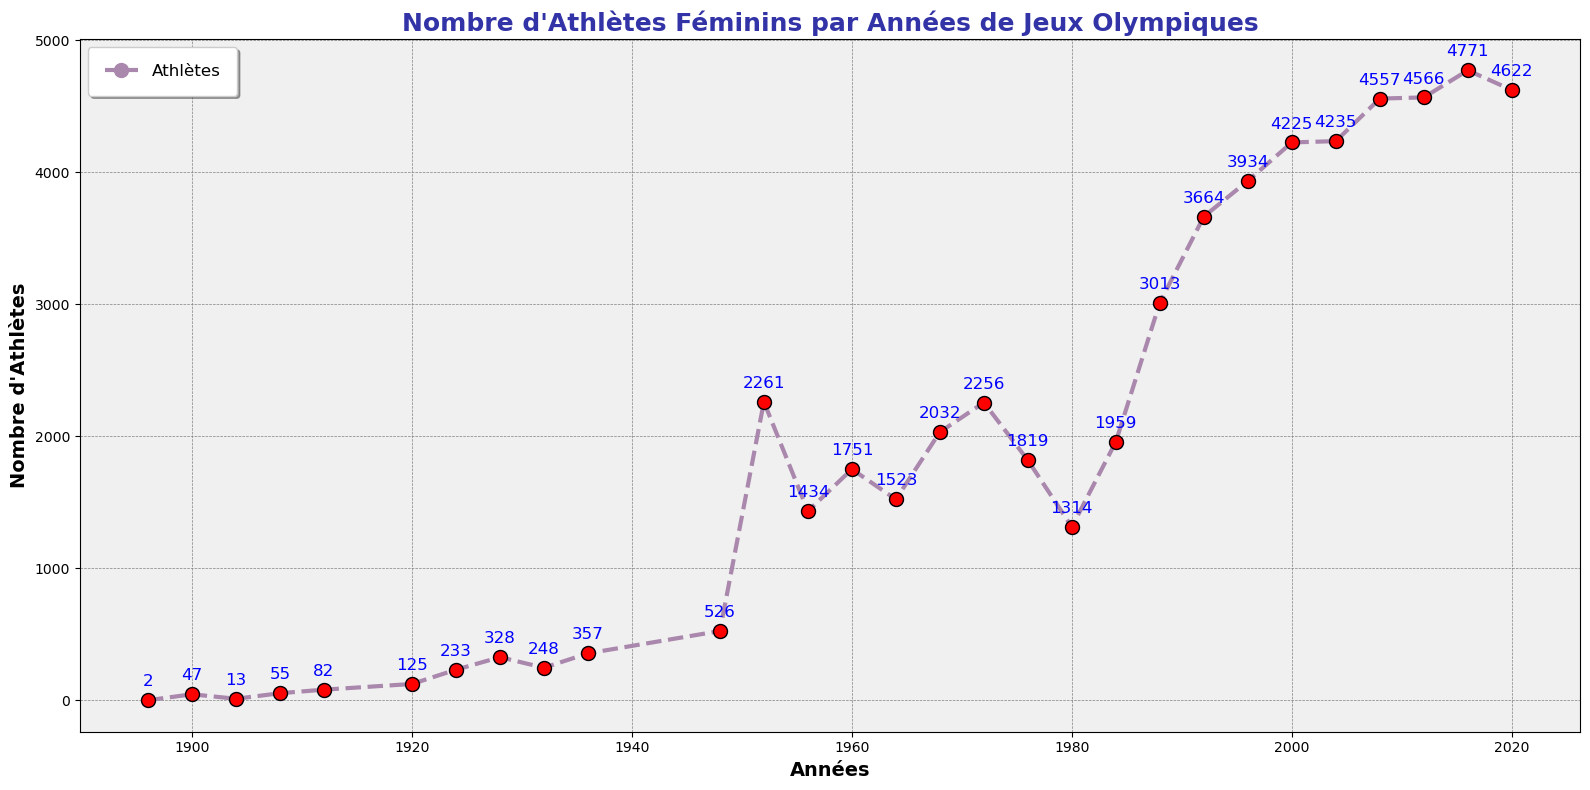

In [43]:
anneeBase = 1896
annees=[]
while anneeBase <= 2020 :
    if anneeBase !=1916 and anneeBase !=1940 and anneeBase !=1944:   #on retire les années ou les JO n'ont pas eu lieu
        annees.append(anneeBase)
    anneeBase+=4
nbAthlPAnnee=[]
for annee in annees : 
    nbAthlPAnnee.append(requete_vers_dataframe(conn,f"""
    SELECT count(*) 
    FROM athlete a
    LEFT JOIN composition_equipe ce ON ce.idAthlete = a.idAthlete
    INNER JOIN participation_individuelle pi ON pi.idAthlete = a.idAthlete
    INNER JOIN evenement e ON e.idEvenement = pi.idEvent
    INNER JOIN hote h ON h.idHote = e.idHote
    WHERE h.libelleHote = '{annee} Summer Olympics' AND GENRE = 'Female'
    """).iloc[0,0])

plt.figure(figsize=(16, 8))
plt.plot(annees, nbAthlPAnnee, label='Athlètes', color='#AA87AC', marker='o', markersize=10, linewidth=3, linestyle='--')

# Personnalisation des marqueurs
plt.scatter(annees, nbAthlPAnnee, color='red', s=100, edgecolor='black', zorder=5)

# Ajout des annotations pour chaque point de données
for i, txt in enumerate(nbAthlPAnnee):
    plt.annotate(txt, (annees[i], nbAthlPAnnee[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color='blue')

# Ajout des légendes et des titres
plt.xlabel('Années', fontsize=14, fontweight='bold')
plt.ylabel('Nombre d\'Athlètes', fontsize=14, fontweight='bold')
plt.title('Nombre d\'Athlètes Féminins par Années de Jeux Olympiques', fontsize=18, fontweight='bold', color='#3333A8')

# Personnalisation de la grille
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# Ajout d'un fond
plt.gca().patch.set_facecolor('#f0f0f0')

# Ajout de légendes
plt.legend(loc='upper left', fontsize=12, frameon=True, shadow=True, borderpad=1)


# Affichage du graphique
plt.tight_layout()
plt.show()

Le nombre d'Athlètes féminin subit de multiples variations au cours du temps, le pic le plus notable étant vers les années 50, les évenements liés à la seconde guerre mondiale ont du y avoir un grand role à jouer. Malgré ces variations avec une chute en 1980, le nombre d'athlètes féminins monte graduellement et tend à se stabiliser au fur et à mesure qu'il se rapproche du nombre d'athlètes masculin.

#### Evolution du nombre d'Evenements feminins au fil du temps

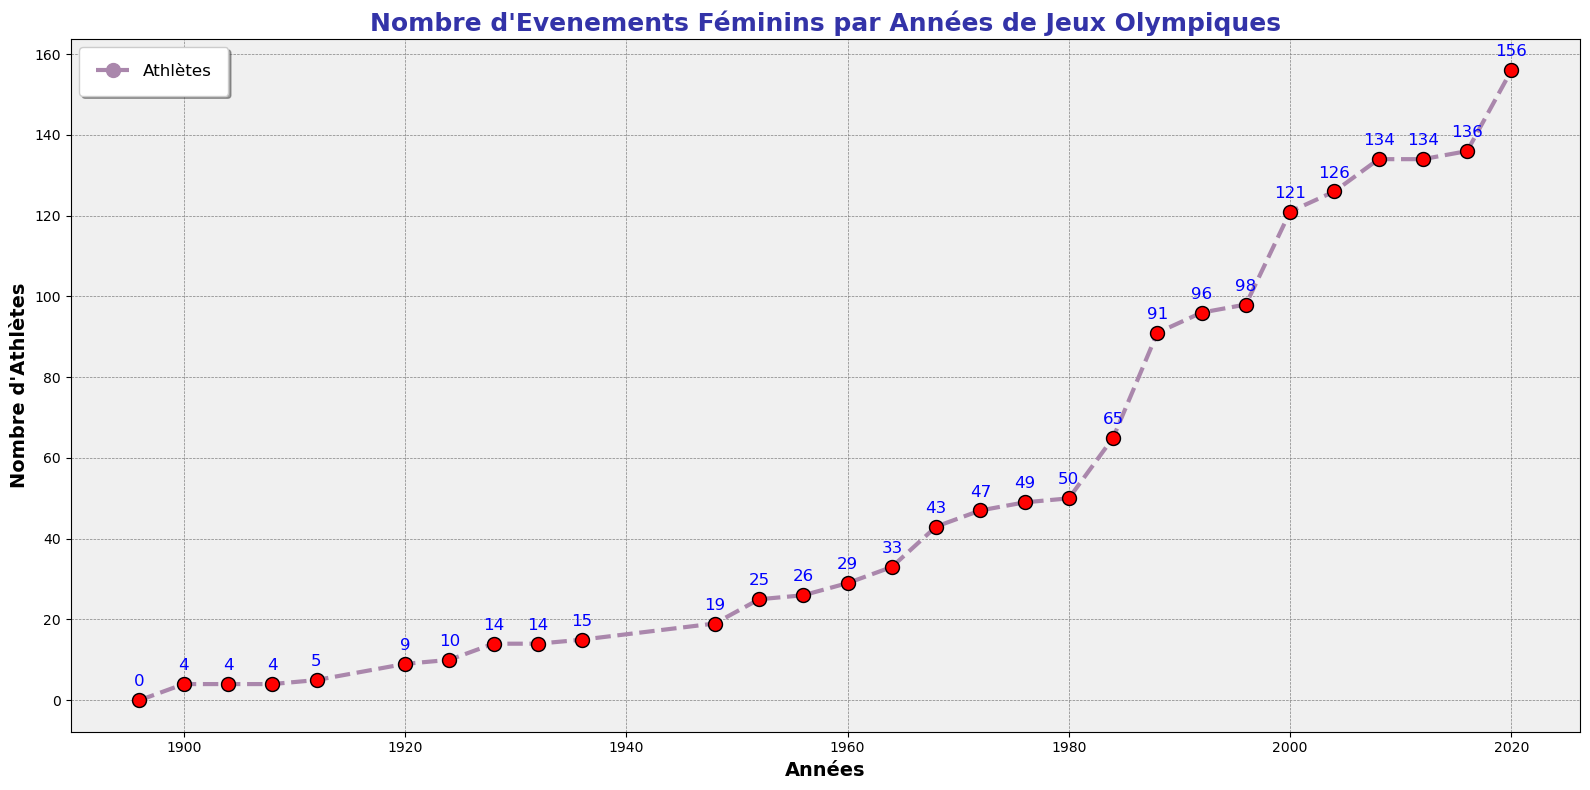

In [44]:
anneeBase = 1896
annees=[]
while anneeBase <= 2020 :
    if anneeBase !=1916 and anneeBase !=1940 and anneeBase !=1944:   #on retire les années ou les JO n'ont pas eu lieu
        annees.append(anneeBase)
    anneeBase+=4
nbAthlPAnnee=[]
for annee in annees : 
    nbAthlPAnnee.append(requete_vers_dataframe(conn,f"""
    select count(*) from evenement e
        inner join hote h on h.idhote=e.idhote
        where substr(nomevenement,-5)='Women' and libelleHote='{annee} Summer Olympics'
    """).iloc[0,0])

plt.figure(figsize=(16, 8))
plt.plot(annees, nbAthlPAnnee, label='Athlètes', color='#AA87AC', marker='o', markersize=10, linewidth=3, linestyle='--')

# Personnalisation des marqueurs
plt.scatter(annees, nbAthlPAnnee, color='red', s=100, edgecolor='black', zorder=5)

# Ajout des annotations pour chaque point de données
for i, txt in enumerate(nbAthlPAnnee):
    plt.annotate(txt, (annees[i], nbAthlPAnnee[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color='blue')

# Ajout des légendes et des titres
plt.xlabel('Années', fontsize=14, fontweight='bold')
plt.ylabel('Nombre d\'Athlètes', fontsize=14, fontweight='bold')
plt.title('Nombre d\'Evenements Féminins par Années de Jeux Olympiques', fontsize=18, fontweight='bold', color='#3333A8')

# Personnalisation de la grille
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# Ajout d'un fond
plt.gca().patch.set_facecolor('#f0f0f0')

# Ajout de légendes
plt.legend(loc='upper left', fontsize=12, frameon=True, shadow=True, borderpad=1)


# Affichage du graphique
plt.tight_layout()
plt.show()

Le nombre d'évènments féminins par année ne traduit aucunement le nombre d'athlètes féminins aux mêmes années, on ne retrouve pas les mêmes pics que précédemment, on a plutôt ici une montée graduelle de ce nombre d'évenements, qui suggère une plus grande ouverture au sport féminin du coté des organisateurs des JO. La comparaison entre ce graphique et le précédent permet d'observer la différence entre les dynamiques sociales de la population et les actions prises par les organisateurs. 

#### Evolution de l'Age Moyen des Athletes de tout genre aux JO au fil du temps

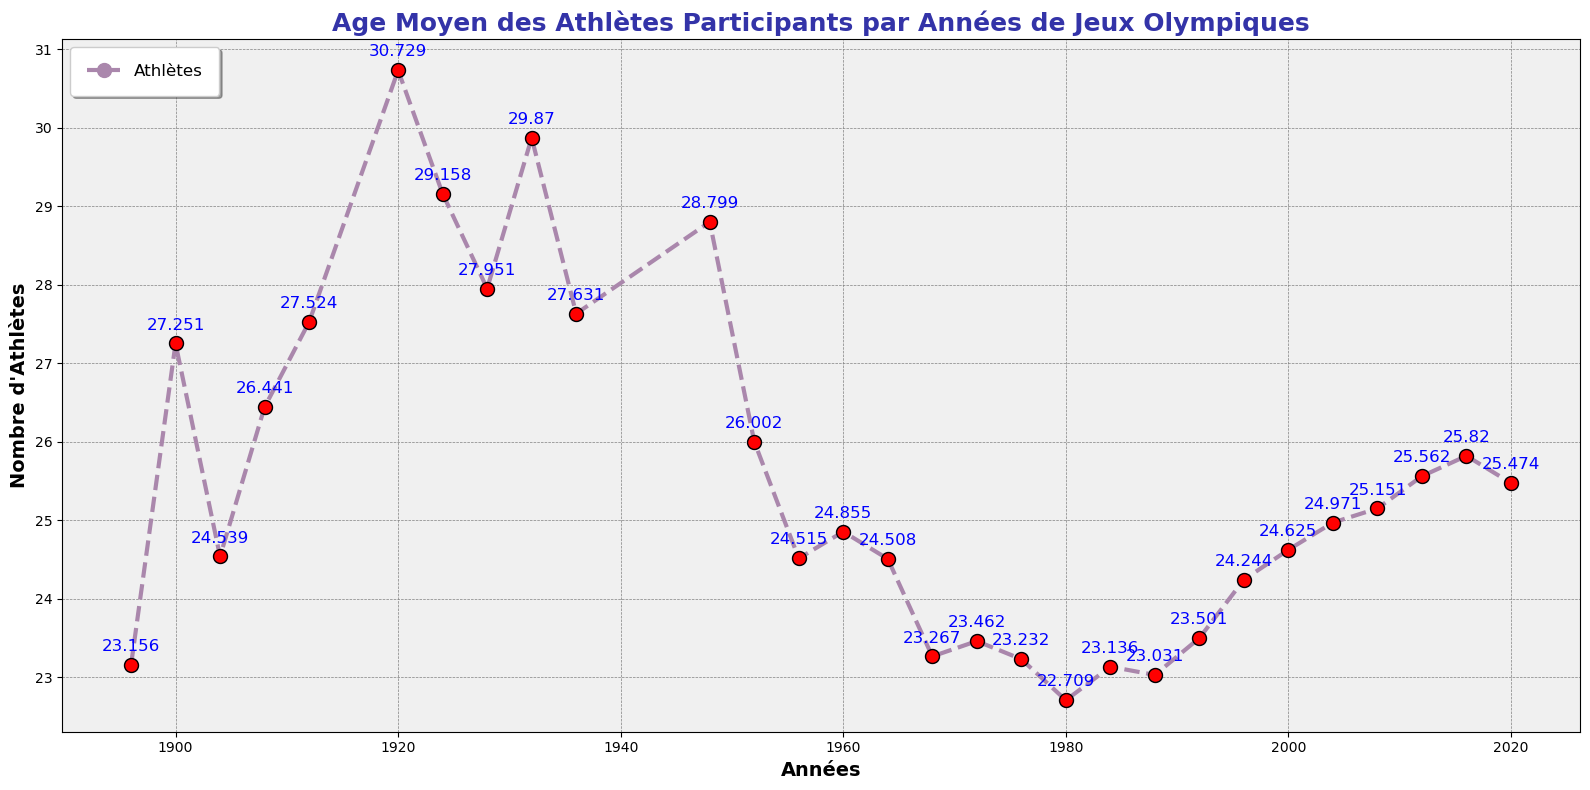

In [45]:
anneeBase = 1896
annees=[]
while anneeBase <= 2020 :
    if anneeBase !=1916 and anneeBase !=1940 and anneeBase !=1944:   #on retire les années ou les JO n'ont pas eu lieu
        annees.append(anneeBase)
    anneeBase+=4
nbAthlPAnnee=[]
for annee in annees : 
    nbAthlPAnnee.append(requete_vers_dataframe(conn,f"""
         SELECT
        ROUND(AVG(CASE 
            WHEN a.datedeces IS NULL THEN
                FLOOR(MONTHS_BETWEEN(TO_DATE('01/01/{annee}', 'DD/MM/YYYY'), a.datenaissance) / 12)
            ELSE
                FLOOR(MONTHS_BETWEEN(TO_DATE('01/01/{annee}', 'DD/MM/YYYY'),a.datenaissance) / 12)
            END),3) AS ageMoyen
        FROM
            athlete a
            LEFT JOIN composition_equipe ce ON ce.idAthlete = a.idAthlete
            INNER JOIN participation_individuelle pi ON pi.idAthlete = a.idAthlete
            INNER JOIN evenement e ON e.idEvenement = pi.idEvent
            INNER JOIN hote h ON h.idHote = e.idHote
        WHERE
            h.libelleHote = '{annee} Summer Olympics'
    """).iloc[0,0])

plt.figure(figsize=(16, 8))
plt.plot(annees, nbAthlPAnnee, label='Athlètes', color='#AA87AC', marker='o', markersize=10, linewidth=3, linestyle='--')

# Personnalisation des marqueurs
plt.scatter(annees, nbAthlPAnnee, color='red', s=100, edgecolor='black', zorder=5)

# Ajout des annotations pour chaque point de données
for i, txt in enumerate(nbAthlPAnnee):
    plt.annotate(txt, (annees[i], nbAthlPAnnee[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color='blue')

# Ajout des légendes et des titres
plt.xlabel('Années', fontsize=14, fontweight='bold')
plt.ylabel('Nombre d\'Athlètes', fontsize=14, fontweight='bold')
plt.title('Age Moyen des Athlètes Participants par Années de Jeux Olympiques', fontsize=18, fontweight='bold', color='#3333A8')

# Personnalisation de la grille
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# Ajout d'un fond
plt.gca().patch.set_facecolor('#f0f0f0')

# Ajout de légendes
plt.legend(loc='upper left', fontsize=12, frameon=True, shadow=True, borderpad=1)


# Affichage du graphique
plt.tight_layout()
plt.show()

 - Pour calculer la moyenne d'age, on passe ici par l'agrégat AVG de SQL, le fonctionnement derrière ce dernier est le suivant : on divise la somme de tous les ages par le nombre total d'athlètes. Exemple pour 2012, la somme de tous les ages des athlètes de 2012 (age en 2012) vaut 262473 et il y a 10268 athlètes participant cette année la, ainsi on a $$\frac{262473}{10268} = 25,562 $$ On retrouve le resultat trouvé par l'ordinateur

# Analyse statistique des performances de l'Australie

#### Nombres d'athlètes représentés 

#### Répartition par genre des médailles remportées par l'Australie

In [46]:
tabTotalFemmes = requete_vers_dataframe(conn, f"""
    SELECT * FROM {SCHEMA}.MEDAILLES_NOC_GENRE_2012 
    WHERE GENRE ='Female' AND CODENOC='AUS'
""")

tabTotalHommes = requete_vers_dataframe(conn, f"""
    SELECT * FROM {SCHEMA}.MEDAILLES_NOC_GENRE_2012 
    WHERE GENRE ='Male' AND CODENOC='AUS'
""")

nbTotalFemmes = requete_vers_dataframe(conn, f"""
    SELECT COUNT(*) AS NBMED FROM {SCHEMA}.ATHL_2012 
    WHERE GENRE ='Female'
""").iloc[0, 0]

nbTotalHommes = requete_vers_dataframe(conn, f"""
    SELECT COUNT(*) FROM {SCHEMA}.ATHL_2012 
    WHERE GENRE ='Male'
""").iloc[0, 0]

listeMedaillesFemmes = tabTotalFemmes['TOTAL_MEDAILLES'].tolist()
listeMedaillesHommes = tabTotalHommes['TOTAL_MEDAILLES'].tolist()

listeOrFemmes=tabTotalFemmes['OR_MEDAILLES'].tolist()
listeOrHommes = tabTotalHommes['OR_MEDAILLES'].tolist()
listeArgentFemmes = tabTotalFemmes['ARGENT_MEDAILLES'].tolist()
listeArgentHommes = tabTotalHommes['ARGENT_MEDAILLES'].tolist()
listeBronzeFemmes = tabTotalFemmes['BRONZE_MEDAILLES'].tolist()
listeBronzeHommes = tabTotalHommes['BRONZE_MEDAILLES'].tolist()



totalMedFemmes = sum(listeMedaillesFemmes)
totalMedHommes = sum(listeMedaillesHommes)

totalOrFemmes = sum(listeOrFemmes)
totalOrHommes = sum(listeOrHommes)

totalArgentFemmes = sum(listeArgentFemmes)
totalArgentHommes = sum(listeArgentHommes)

totalBronzeFemmes = sum(listeBronzeFemmes)
totalBronzeHommes = sum(listeBronzeHommes)

moyenneMedFemmes = totalMedFemmes / nbTotalFemmes
moyenneMedHommes = totalMedHommes / nbTotalHommes

moyenneOrFemmes = totalOrFemmes / nbTotalFemmes
moyenneOrHommes = totalOrHommes / nbTotalHommes

moyenneArgentFemmes = totalArgentFemmes / nbTotalFemmes
moyenneArgentHommes = totalArgentHommes / nbTotalHommes

moyenneBronzeFemmes = totalBronzeFemmes / nbTotalFemmes
moyenneBronzeHommes = totalBronzeHommes / nbTotalHommes

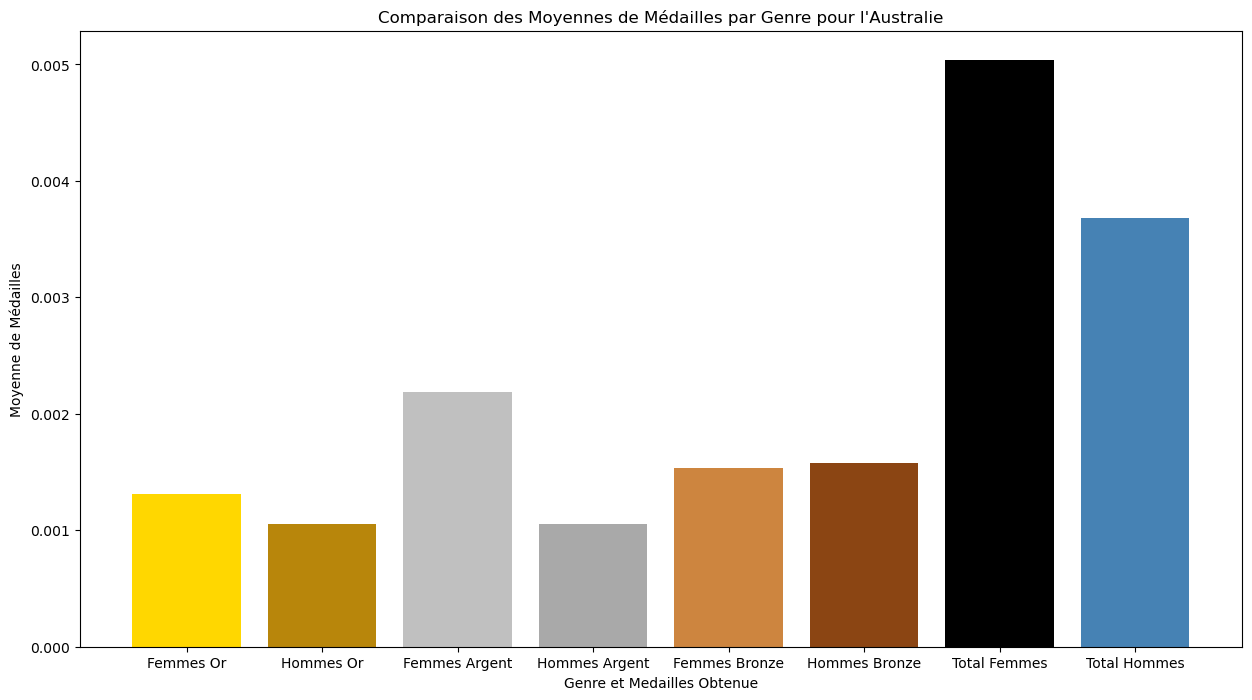

In [47]:
genresAus = ['Femmes Or', 'Hommes Or', 'Femmes Argent', 'Hommes Argent', 'Femmes Bronze', 'Hommes Bronze','Total Femmes', 'Total Hommes']
moyennesAus = [
    moyenneOrFemmes, moyenneOrHommes,
    moyenneArgentFemmes, moyenneArgentHommes,
    moyenneBronzeFemmes, moyenneBronzeHommes,
    moyenneMedFemmes,moyenneMedHommes
]
"""totaux = [
    totalOrFemmes, totalOrHommes,
    totalArgentFemmes, totalArgentHommes,
    totalBronzeFemmes, totalBronzeHommes,
    totalMedFemmes, totalMedHommes
]"""   #Possibilité d'utiliser ceci pour comparer 



plt.figure(figsize=(15,8))
plt.bar(genresAus,moyennesAus, color=['gold', 'darkgoldenrod', 'silver', 'darkgray', 'peru', 'saddlebrown','black','steelblue'])
plt.xlabel('Genre et Medailles Obtenue')
plt.ylabel('Moyenne de Médailles')
plt.title('Comparaison des Moyennes de Médailles par Genre pour l\'Australie')
plt.show()

#### Nombre de médailles

In [48]:
# Liste des requêtes SQL avec leurs libellés
queries = [
    ("Résultats pour les Jeux Olympiques d'été 2012",
     """
     SELECT sum(medaille_count) as total_medals FROM (
         SELECT count(pe.medaille) as medaille_count
         FROM participation_equipe pe
         INNER JOIN evenement e on e.idevenement = pe.idevenement
         INNER JOIN equipe eq on eq.idequipe = pe.idequipe
         INNER JOIN noc n on n.codenoc = eq.noc
         INNER JOIN hote h on h.idhote=e.idhote
         WHERE n.codenoc = 'AUS' and h.libellehote = '2012 Summer Olympics'
         
         UNION 
         
         SELECT count(pi.medaille) as medaille_count
         FROM participation_individuelle pi
         INNER JOIN evenement e on e.idevenement = pi.idevent
         INNER JOIN noc n on n.codenoc = pi.noc
         INNER JOIN hote h on h.idhote=e.idhote
         WHERE n.codenoc = 'AUS' and h.libellehote = '2012 Summer Olympics'
     )
     """),
    ("Résultats pour les Jeux Olympiques d'été 2008",
     """
     SELECT sum(medaille_count) as total_medals FROM (
         SELECT count(pe.medaille) as medaille_count
         FROM participation_equipe pe
         INNER JOIN evenement e on e.idevenement = pe.idevenement
         INNER JOIN equipe eq on eq.idequipe = pe.idequipe
         INNER JOIN noc n on n.codenoc = eq.noc
         INNER JOIN hote h on h.idhote=e.idhote
         WHERE n.codenoc = 'AUS' and h.libellehote = '2008 Summer Olympics'
         
         UNION 
         
         SELECT count(pi.medaille) as medaille_count
         FROM participation_individuelle pi
         INNER JOIN evenement e on e.idevenement = pi.idevent
         INNER JOIN noc n on n.codenoc = pi.noc
         INNER JOIN hote h on h.idhote=e.idhote
         WHERE n.codenoc = 'AUS' and h.libellehote = '2008 Summer Olympics'
     )
     """),
    ("Résultats pour les Jeux Olympiques d'été 2004",
     """
     SELECT sum(medaille_count) as total_medals FROM (
         SELECT count(pe.medaille) as medaille_count
         FROM participation_equipe pe
         INNER JOIN evenement e on e.idevenement = pe.idevenement
         INNER JOIN equipe eq on eq.idequipe = pe.idequipe
         INNER JOIN noc n on n.codenoc = eq.noc
         INNER JOIN hote h on h.idhote=e.idhote
         WHERE n.codenoc = 'AUS' and h.libellehote = '2004 Summer Olympics'
         
         UNION 
         
         SELECT count(pi.medaille) as medaille_count
         FROM participation_individuelle pi
         INNER JOIN evenement e on e.idevenement = pi.idevent
         INNER JOIN noc n on n.codenoc = pi.noc
         INNER JOIN hote h on h.idhote=e.idhote
         WHERE n.codenoc = 'AUS' and h.libellehote = '2004 Summer Olympics'
     )
     """)
]

# Exécution des requêtes et affichage des résultats
for label, sql_query in queries:
    print(f"\n{label}:")
    result = requete_vers_dataframe(conn, sql_query).iloc[0,0]
    print(f"Total des médailles de l'Australie: {result}")


Résultats pour les Jeux Olympiques d'été 2012:
Total des médailles de l'Australie: 35

Résultats pour les Jeux Olympiques d'été 2008:
Total des médailles de l'Australie: 46

Résultats pour les Jeux Olympiques d'été 2004:
Total des médailles de l'Australie: 50


#### Nombre de médaillés

In [55]:
def grapheAustralieNbAthletesMedaillees(data):
    
    # Sample data
    
    
    annees = [row[0] for row in data]
    nbMedaillees = [row[1] for row in data]
    
    plt.figure(figsize=(12, 6))
     # Creating positions for each group of bars
    # Creating positions for each group of bars
    x = np.arange(len(annees))  # the label locations
    bar_width = 0.25  # the width of the bars

    # Creating the bar chart
    plt.figure(figsize=(12, 6))

    plt.plot(annees, nbMedaillees, label='Nombre de médaillés/médaillées', color='orange')
    
    # Creating the bar chart

    # Adding title and labels
    plt.title("""Evolution du nombre d'athlètes australiens/australiennes médaillés/médaillées par édition (été)""")
    plt.xlabel('Edition')
    plt.ylabel("Nombre d'athlètes médaillés/médailées")
    plt.legend()

    # Displaying the bar chart
    plt.show()


<Figure size 1200x600 with 0 Axes>

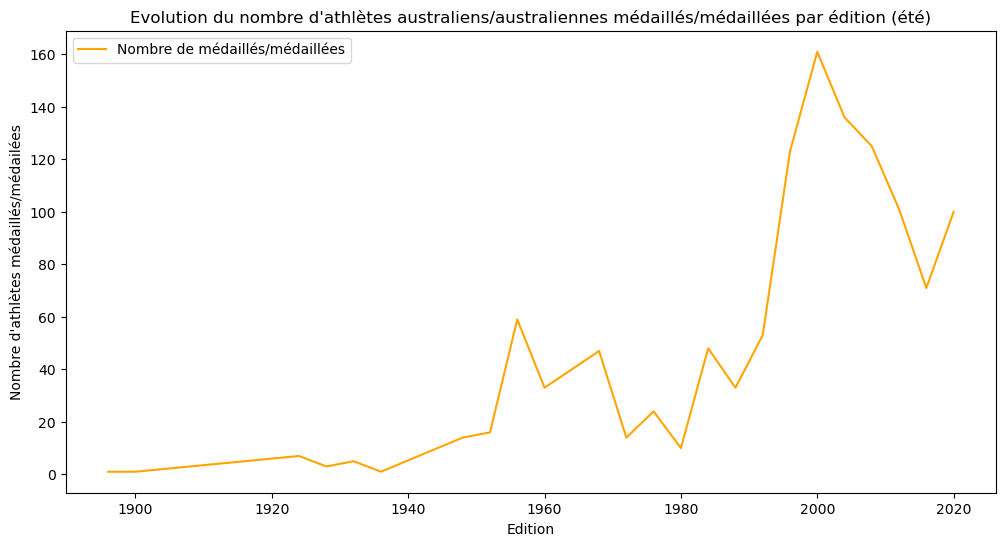

In [56]:
with Connexion(login=conn['login'], password=conn['password']) as connexion:        
     
    connexion.begin()
    curseur = connexion.cursor()
    #### top 3 
    curseur.execute(f"""SELECT * FROM {SCHEMA}.NB_ATH_MEDAILLEES_HOTES_AUS WHERE nbAthletes IS NOT NULL""")
    data = curseur.fetchall()  # Renvoie un tuple, on veut le premier élément du tuple
    grapheAustralieNbAthletesMedaillees(data)
    

### Evolution de l'âge moyen 

In [57]:
def grapheAustralieAgeMoyen(data):
    
    
    annees = [row[1] for row in data]
    ageMoyen = [row[2] for row in data]
    
    plt.figure(figsize=(12, 6))
    x = np.arange(len(annees))
    bar_width = 0.25
    plt.figure(figsize=(12, 6))

    plt.plot(annees, ageMoyen, label='Age moyen des athlètes', color='orange')
    

    plt.title("""Evolution de l'âge moyen des athlètes australiens/australiennes par édition (été)""")
    plt.xlabel('Edition')
    plt.ylabel("Age moyen")
    plt.legend()
    plt.show()


<Figure size 1200x600 with 0 Axes>

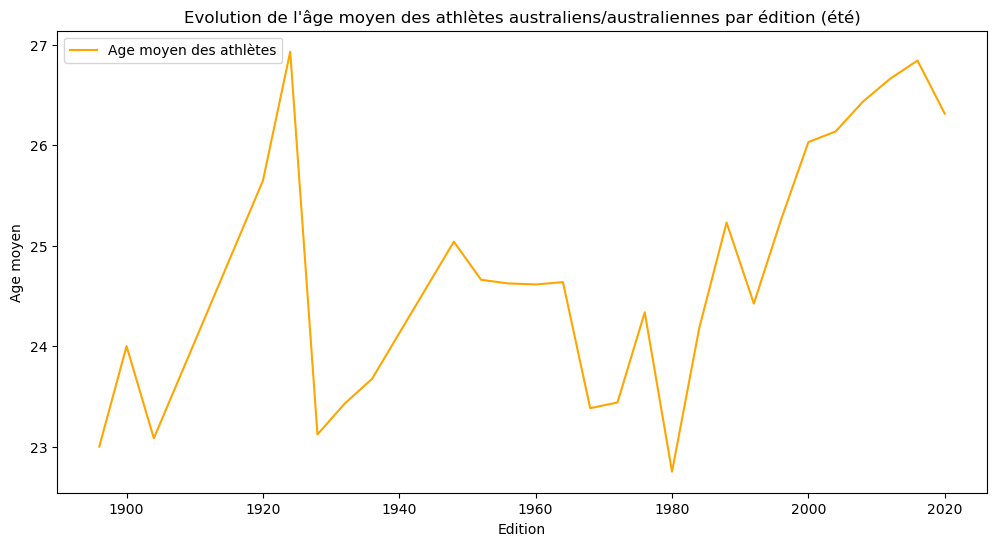

In [58]:
with Connexion(login=conn['login'], password=conn['password']) as connexion:        
    connexion.begin()
    curseur = connexion.cursor()
    #### top 3 
    curseur.execute(f"""SELECT * FROM {SCHEMA}.AGE_MOYEN_NOC_HOTES WHERE CODENOC='AUS'""")
    data = curseur.fetchall()  # Renvoie un tuple, on veut le premier élément du tuple
    grapheAustralieAgeMoyen(data)
    

## Prévision des résultats futurs en fonction des résultats passés

### Cherchons un lien entre le nombre d'athlètes et le nombre de médailles remportées
### Cherchons la fonction $y=ax+b$ tel que : 

## $$ a = \frac{\text{cov}(x, y)}{V(x)}\ et\  b = \overline{y} - a \overline{x} $$


In [59]:
def moyenne(x):
    return sum(x)/len(x)

def cov(x,y):
    s = 0
    mX = moyenne(x)
    mY = moyenne(y)
    for i in range(len(x)):
        s+=(x[i]-mX)*(y[i]-mY)
    return s*(1/len(x))
        
def V(x):
    mX = moyenne(x)
    s = 0
    for i in range(len(x)):
        s+=(x[i]-mX)**2
    return s*(1/len(x))

def a_(x,y):
    return cov(x,y)/V(x)

def b_(x, y, a):
    mX = moyenne(x)
    mY = moyenne(y)
    return mY-a*mX


def f(x, a, b):
    return a*x+b


In [60]:
def dataNbMedaillesNbAthletes():
    with Connexion(login=conn['login'], password=conn['password']) as connexion:  # Démarre une nouvelle connexion
        connexion.begin()
        curseur = connexion.cursor()
        #### top 3 
        curseur.execute(f"""SELECT * FROM {SCHEMA}.NB_MEDAILLES_NB_ATH_ANNEE_AUS""")
        data = curseur.fetchall()  # Renvoie un tuple, on veut le premier élément du tuple
        annees = [row[0] for row in data]
        nbAthletes = [row[1] for row in data]
        nbAthletesFemmes = [row[2] for row in data]
        nbAthletesHommes = [row[3] for row in data]
        nbMedailles = [row[4] for row in data]
        return annees, nbAthletes, nbAthletesFemmes, nbAthletesHommes,nbMedailles

In [61]:
annees, nbAthletes, nbAthletesFemmes, nbAthletesHommes,nbMedailles = dataNbMedaillesNbAthletes() 

def coeffsPredictionTotalMedaillesJo2024NbAthletes():
    a = a_(nbAthletes, nbMedailles)
    b = b_(nbAthletes, nbMedailles, a)
    """
    for i in range(len(nbAthletes)):
        pred = f(nbAthletes[i], a, b)
        reel = nbMedailles[i]
        diff = abs(pred-reel)
        
        print("Nb Athlètes = " + str(nbAthletes[i]))
        print("Prédiction nb Médailles: " + str(pred))
        print("nb Médailles réel : " + str(reel) + " Diff " + str(diff)+  "\n")
    """
    return a, b
    
    


### L'Australie enverra une délégation d'environ 470 athlètes au JO de Paris en 2024

In [62]:
NB_ATH_JO_2024 = 470

In [63]:
def graphePredictionsNbMedailles():
    a, b = coeffsPredictionTotalMedaillesJo2024NbAthletes()
    
    x_nbAthletes = np.array(nbAthletes)
    y_nbMedailles = np.array(nbMedailles)
    x_line = np.linspace(min(x_nbAthletes), max(x_nbAthletes), 100)

    y_line = a * x_line + b
    
    predictionJO2024 = round(a * NB_ATH_JO_2024 + b)

    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x_nbAthletes, y_nbMedailles, color='blue', label='Données réelles')
    plt.plot(x_line, y_line, label=f'y = {round(a,3)}x + {round(b,3)}', color='green')
    plt.scatter(NB_ATH_JO_2024, predictionJO2024, color='red', zorder=5, label=f'Prédiction pour les JO 2024\n ({NB_ATH_JO_2024} athlètes): {predictionJO2024} médailles')
    plt.xlabel("Nombre d'athlètes")
    plt.ylabel('Nombre de médailles')
    plt.title("""Lien entre nombre d'athlètes et nombre de médailles""")
    plt.legend()
    plt.grid(True)
    plt.show()

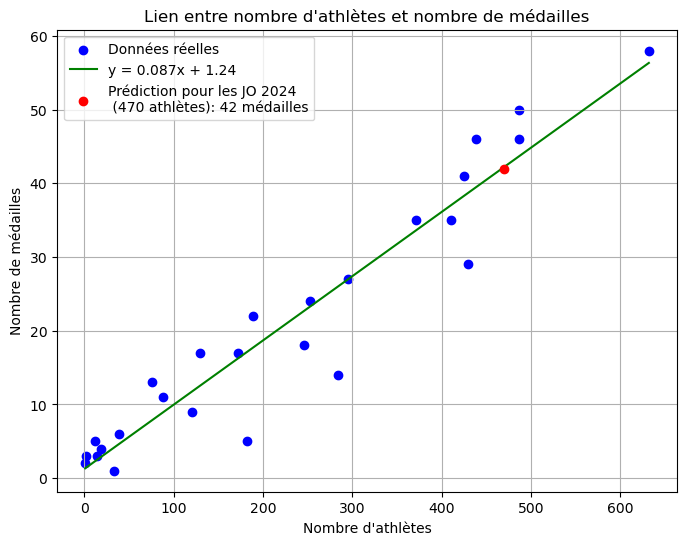

In [64]:
graphePredictionsNbMedailles()

## L'Australie pourrait remporter 42 médailles au JO 2024 à Paris